In [1]:
import sys
import scipy.stats
from scipy.signal import coherence
from scipy.cluster.hierarchy import fcluster
from sklearn import metrics
from sklearn.linear_model import LinearRegression

from trajectory_process import traj_process

import numpy as np
from scipy.cluster import hierarchy
from sklearn import cluster
import matplotlib.pyplot as plt
import seaborn as sns
# %matplotlib notebook
import glob
import re  # Regular expression operations
import pandas as pd
from scipy import signal
import mne
from tqdm import tqdm
import os
from os.path import exists
from pathlib import Path
import pickle
import statsmodels.stats.api as sms

# base_dir = '/home/fu/Data/ephys/'
base_dir = 'D:\\ephys\\'

import utils
import ephys
import plotting

plt.rcParams["axes.labelsize"] = 12
plt.rcParams["font.size"] = 7
# plt.rcParams["font.family"] = "Arial"

mBWfus009 = {
    'arena_0219': '2021-02-19_mBWfus009_arena_ephys',
    'ezm_0219': '2021-02-19_mBWfus009_EZM_ephys',
    'oft_0219': '2021-02-19_mBWfus009_OF_ephys',

    'arena_0226': '2021-02-26_mBWfus009_arena_ephys',
    'ezm_0226': '2021-02-26_mBWfus009_EZM_ephys',
    'oft_0226': '2021-02-26_mBWfus009_OF_ephys',

    'arena_0305_bef': '2021-03-05_mBWfus009_before_arena_ephys',
    'cage_0305': '2021-03-05_mBWfus009_cage_arena_ephys',
    'arena_0305_aft': '2021-03-05_mBWfus009_after_arena_ephys',
    'ezm_0305': '2021-03-05_mBWfus009_EZM_ephys',
    'oft_0305': '2021-03-05_mBWfus009_OF_ephys',

    'arena_0325': '2021-03-25_mBWfus009_arena_ephys',
    'epm_0325': '2021-03-25_mBWfus009_EPM_ephys'
}

mBWfus008 = {
    'arena_0219': '2021-02-19_mBWfus008_arena_ephys',
    'ezm_0219': '2021-02-19_mBWfus008_EZM_ephys',
    'oft_0219': '2021-02-19_mBWfus008_OF_ephys',

    'arena_0226': '2021-02-26_mBWfus008_arena_ephys',
    'ezm_0226': '2021-02-26_mBWfus008_EZM_ephys',
    'oft_0226': '2021-02-26_mBWfus008_OF_ephys',

    'arena_0305_bef': '2021-03-05_mBWfus008_before_arena_ephys',
    'cage_0305': '2021-03-05_mBWfus008_cage_arena_ephys',
    'arena_0305_aft': '2021-03-05_mBWfus008_after_arena_ephys',
    'ezm_0305': '2021-03-05_mBWfus008_EZM_ephys',
    'oft_0305': '2021-03-05_mBWfus008_OF_ephys',
}

mBWfus010 = {
    'arena_0219': '2021-02-19_mBWfus010_arena_ephys',
    'ezm_0219': '2021-02-19_mBWfus010_EZM_ephys',
    'oft_0219': '2021-02-19_mBWfus010_OF_ephys',

    'arena_0301_aft': '2021-03-01_mBWfus010_arena_ephys_after',
    'arena_0301_bef': '2021-03-01_mBWfus010_arena_ephys_before',
    'cage_0301': '2021-03-01_mBWfus010_cage_ephys',
    'oft_0301': '2021-03-01_mBWfus010_OF_ephys',
    'ezm_0301': '2021-03-01_mBWfus010_EZM_ephys',

    'arena_0307_bef': '2021-03-07_mBWfus010_after_arena_ephys',
    'cage_0307': '2021-03-07_mBWfus010_cage_arena_ephys',
    'arena_0307_aft': '2021-03-07_mBWfus010_after_arena_ephys',
    'ezm_0307': '2021-03-07_mBWfus010_EZM_ephys',
    'oft_0307': '2021-03-07_mBWfus010_OF_ephys',
}

mBWfus011 = {
    'arena_0226': '2021-02-26_mBWfus011_arena_ephys',
    'ezm_0226': '2021-02-26_mBWfus011_EZM_ephys',
    'oft_0226': '2021-02-26_mBWfus011_OF_ephys',

    'arena_0305_aft': '2021-03-05_mBWfus011_after_arena_ephys',
    'cage_0305': '2021-03-05_mBWfus011_cage_arena_ephys',
    'arena_0305_bef': '2021-03-05_mBWfus011_before_arena_ephys',
    'oft_0305': '2021-03-05_mBWfus011_OF_ephys',
    'ezm_0305': '2021-03-05_mBWfus011_EZM_ephys',

    'arena_0313_bef': '2021-03-13_mBWfus011_before_arena_ephys',
    'cage_0313': '2021-03-13_mBWfus011_cage_arena_ephys',
    'arena_0313_aft': '2021-03-13_mBWfus011_after_arena_ephys',
    'ezm_0313': '2021-03-13_mBWfus011_EZM_ephys',
    'oft_0313': '2021-03-13_mBWfus011_OF_ephys',
}

mBWfus012 = {
    'arena_0226': '2021-02-26_mBWfus012_arena_ephys',
    'ezm_0226': '2021-02-26_mBWfus012_EZM_ephys',
    'oft_0226': '2021-02-26_mBWfus012_OF_ephys',
}

In [2]:
np.random.seed(42)
animal = mBWfus011
session = 'ezm_0305'
behavior_trigger = 4.56 # time when LED is turned off
start_time = 0.0 # time when animal is put onto maze
savedir='./results_EZM/011_0305_EZM/'

exclude = [29, 30, 31, 34, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63]

In [ ]:
session_arena = 'arena_0226'
behavior_trigger_arena = 5.90 # time when LED is turned off
start_time_arena = 0.0 # time when animal is put onto maze
savedir_arena='./results_arena/012_0226_arena/'

D:\ephys\2021-03-05_mBWfus011_EZM_ephys/ephys_processed/
total number of frames: 47422
frames to process: 45000
edited 2119 data points


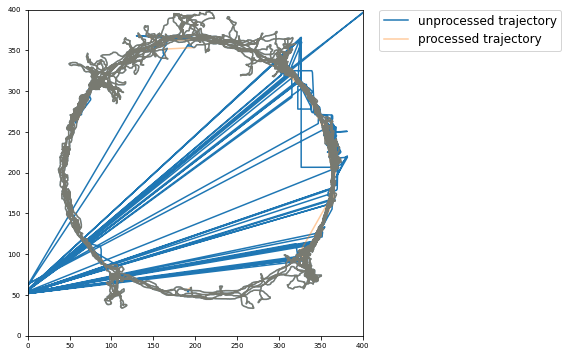

Number of open-to-closed crossings detected: 3
Number of closed-to-open crossings detected: 0
Number of lingerings in transition region detected: 30
Number of prolonged open to closed crossings detected: 9
Number of prolonged closed to open crossings detected: 12
Number of withdraws detected: 9
Number of nosedips detected: 39


In [4]:
f_behavior = 50
f_ephys = 500
behavior_window_duration = 900
ephys_window_duration = 1000
events = traj_process(base_dir, animal[session], behavior='ezm', start_time=start_time, duration=behavior_window_duration)

# ### extract overall behavioral open/close frame indices
open_idx = [i for i, el in enumerate(
    events['rois_stats']['roi_at_each_frame'][
    int(f_behavior * behavior_trigger):int(f_behavior * behavior_trigger) + f_behavior * behavior_window_duration])
            if
            el == 'open']
close_idx = [i for i, el in enumerate(
    events['rois_stats']['roi_at_each_frame'][
    int(f_behavior * behavior_trigger):int(f_behavior * behavior_trigger) + f_behavior * behavior_window_duration])
             if
             el == 'closed']
open_to_close_idx = np.array(events['transitions']['open_closed_exittime']) - int(f_behavior * behavior_trigger)
prolonged_close_to_open_idx = np.array(events['transitions']['prolonged_open_closed_exittime']) - int(
    f_behavior * behavior_trigger)
prolonged_open_to_close_idx = np.array(events['transitions']['prolonged_closed_open_exittime']) - int(
    f_behavior * behavior_trigger)

In [5]:
dataset = ephys.load_data(base_dir, animal[session])

2021-03-05_mBWfus011_EZM_ephys


In [ ]:
behavior_window_duration_arena = 900
events_arena = traj_process(base_dir, animal[session_arena], behavior='arena', start_time=start_time_arena, duration=behavior_window_duration_arena)

In [ ]:
plotting.pair_power_phase(dataset, animal, session, 18, 38, tstart=40.0, twin=2)

In [ ]:
plotting.pair_power_lag(dataset, animal, session, 18, 38, tstart=83.24, twin=.5)

In [ ]:
plotting.pair_power_lag(dataset, animal, session, 18, 38, tstart=40.0, twin=900)

In [ ]:
inner_circle = plt.Circle((202, 204), 144, color='k', fill=False)
outer_circle = plt.Circle((202, 204), 176, color='k', fill=False)
#edges
x1, y1 = [360, 44], [388, 20]
x2, y2 = [400, 4], [40, 368]

fig, ax = plt.subplots(figsize=(10,10))
ax.add_patch(inner_circle)
ax.add_patch(outer_circle)
ax.plot(x1, y1, color='k')
ax.plot(x2, y2, color='k')
ax.set_xlim(0, 400)
ax.set_ylim(0, 400)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

traj_x = events['movement']['calib_traj_x']
traj_y = events['movement']['calib_traj_y']
rois = events['rois_stats']['roi_at_each_frame']
beh_start = int(start_time * f_behavior)
beh_end = int((start_time + behavior_window_duration) * f_behavior)
for i in range(beh_start, beh_end):
    if rois[i]=='closed':
        ax.scatter(traj_x[i], traj_y[i], alpha=0.6, c='b', s=.05)

plt.show()

## Phase and Time Lag Analysis

In [ ]:
phase_diff_resultfilename_open = animal[session] + '_phase_diff_results_open.pkl'
phase_diff_resultfile_open = Path(savedir + phase_diff_resultfilename_open)
phase_diff_resultfilename_closed = animal[session] + '_phase_diff_results_closed.pkl'
phase_diff_resultfile_closed = Path(savedir + phase_diff_resultfilename_closed)
try:
    save_filename = phase_diff_resultfile_open.resolve(strict=True)
except FileNotFoundError:
    print('first generating result file (phase-diff-open)')
    results_phase_diff_open = ephys.get_phase_diffs(dataset, animal, session, start_time, behavior_window_duration, exclude, 64, open_idx)
    save_filename = animal[session] + '_phase_diff_results_open.pkl'
    with open(savedir + save_filename, 'wb') as handle:
        pickle.dump(results_phase_diff_open, handle, protocol=3)
else:
    with open(savedir + phase_diff_resultfilename_open, 'rb') as handle:
        results_phase_diff_open = pickle.load(handle)
    print('result file (phase-diff-open) already generated')

try:
    save_filename = phase_diff_resultfile_closed.resolve(strict=True)
except FileNotFoundError:
    print('first generating result file (phase-diff-closed)')
    results_phase_diff_closed = ephys.get_phase_diffs(dataset, animal, session, start_time, behavior_window_duration, exclude, 64, close_idx)
    save_filename = animal[session] + '_phase_diff_results_closed.pkl'
    with open(savedir + save_filename, 'wb') as handle:
        pickle.dump(results_phase_diff_closed, handle, protocol=3)
else:
    with open(savedir + phase_diff_resultfilename_closed, 'rb') as handle:
        results_phase_diff_closed = pickle.load(handle)
    print('result file (phase-diff-closed) already generated')

In [ ]:
plotting.plot_phase_diffs(results_phase_diff_open, savedir+'phase_diff_distrib_open/')
plotting.plot_phase_diffs(results_phase_diff_closed, savedir+'phase_diff_distrib_closed/')

In [ ]:
phase_diff_resultfilename_arena = animal[session_arena] + '_phase_diff_results_arena.pkl'
phase_diff_resultfile_arena = Path(savedir_arena + phase_diff_resultfilename_arena)
try:
    save_filename = phase_diff_resultfile_arena.resolve(strict=True)
except FileNotFoundError:
    print('first generating result file (phase-diff-arena)')
    results_phase_diff_arena = ephys.get_phase_diffs(dataset, animal, session_arena, start_time_arena, behavior_window_duration_arena, exclude, 64, None)
    save_filename = animal[session_arena] + '_phase_diff_results_arena.pkl'
    with open(savedir_arena + save_filename, 'wb') as handle:
        pickle.dump(results_phase_diff_arena, handle, protocol=3)
else:
    with open(savedir_arena + phase_diff_resultfilename_arena, 'rb') as handle:
        results_phase_diff_arena = pickle.load(handle)
    print('result file (phase-diff-arena) already generated')

In [ ]:
plotting.plot_phase_diffs(results_phase_diff_arena, savedir_arena+'phase_diff_distrib_arena/')

In [ ]:
FWHM_open = ephys.get_FWHM(results_phase_diff_open)
FWHM_closed = ephys.get_FWHM(results_phase_diff_closed)
FWHM_arena = ephys.get_FWHM(results_phase_diff_arena)

FWHM_diff_open_arena = {key: value[:] for key, value in FWHM_open.items()}
FWHM_diff_open_arena['FWHMs'] = FWHM_open['FWHMs'] - FWHM_arena['FWHMs']

FWHM_diff_closed_arena = {key: value[:] for key, value in FWHM_closed.items()}
FWHM_diff_closed_arena['FWHMs'] = FWHM_closed['FWHMs'] - FWHM_arena['FWHMs']

plotting.plot_FWHM(FWHM_open, savedir, 'open')
plotting.plot_FWHM(FWHM_closed, savedir, 'closed')
plotting.plot_FWHM(FWHM_diff_open_arena, savedir, 'diff_open_to_arena')
plotting.plot_FWHM(FWHM_diff_closed_arena, savedir, 'diff_closed_to_arena')

In [6]:
seg_lag_resultfilename_open = animal[session] + '_seg_lag_results_open.pkl'
seg_lag_resultfile_open = Path(savedir + seg_lag_resultfilename_open)
seg_lag_resultfilename_closed = animal[session] + '_seg_lag_results_closed.pkl'
seg_lag_resultfile_closed = Path(savedir + seg_lag_resultfilename_closed)
try:
    save_filename = seg_lag_resultfile_open.resolve(strict=True)
except FileNotFoundError:
    print('first generating result file (seg_lag-open)')
    results_seg_lag_open = ephys.get_seg_lags(dataset, animal, session, start_time, behavior_window_duration, exclude, 0.5, open_idx)
    save_filename = animal[session] + '_seg_lag_results_open.pkl'
    with open(savedir + save_filename, 'wb') as handle:
        pickle.dump(results_seg_lag_open, handle, protocol=3)
else:
    with open(savedir + seg_lag_resultfilename_open, 'rb') as handle:
        results_seg_lag_open = pickle.load(handle)
    print('result file (seg_lag-open) already generated')

try:
    save_filename = seg_lag_resultfile_closed.resolve(strict=True)
except FileNotFoundError:
    print('first generating result file (seg_lag-closed)')
    results_seg_lag_closed = ephys.get_seg_lags(dataset, animal, session, start_time, behavior_window_duration, exclude, 0.5, close_idx)
    save_filename = animal[session] + '_seg_lag_results_closed.pkl'
    with open(savedir + save_filename, 'wb') as handle:
        pickle.dump(results_seg_lag_closed, handle, protocol=3)
else:
    with open(savedir + seg_lag_resultfilename_closed, 'rb') as handle:
        results_seg_lag_closed = pickle.load(handle)
    print('result file (seg_lag-closed) already generated')

first generating result file (seg_lag-open)
Number of time segments extracted:  486
mPFC-ch-0
rejected by out-of-100ms-range: 26
rejected not-passing-bootstrap: 76
rejected by out-of-100ms-range: 34
rejected not-passing-bootstrap: 80
rejected by out-of-100ms-range: 13
rejected not-passing-bootstrap: 64
rejected by out-of-100ms-range: 16
rejected not-passing-bootstrap: 66
rejected by out-of-100ms-range: 15
rejected not-passing-bootstrap: 60
rejected by out-of-100ms-range: 15
rejected not-passing-bootstrap: 59
mPFC-ch-1
rejected by out-of-100ms-range: 22
rejected not-passing-bootstrap: 78
rejected by out-of-100ms-range: 33
rejected not-passing-bootstrap: 80
rejected by out-of-100ms-range: 10
rejected not-passing-bootstrap: 60
rejected by out-of-100ms-range: 11
rejected not-passing-bootstrap: 57
rejected by out-of-100ms-range: 11
rejected not-passing-bootstrap: 59
rejected by out-of-100ms-range: 10
rejected not-passing-bootstrap: 61
mPFC-ch-2
rejected by out-of-100ms-range: 22
rejected no

rejected by out-of-100ms-range: 7
rejected not-passing-bootstrap: 66
rejected by out-of-100ms-range: 7
rejected not-passing-bootstrap: 61
rejected by out-of-100ms-range: 7
rejected not-passing-bootstrap: 63
mPFC-ch-20
rejected by out-of-100ms-range: 17
rejected not-passing-bootstrap: 87
rejected by out-of-100ms-range: 23
rejected not-passing-bootstrap: 67
rejected by out-of-100ms-range: 6
rejected not-passing-bootstrap: 57
rejected by out-of-100ms-range: 6
rejected not-passing-bootstrap: 59
rejected by out-of-100ms-range: 6
rejected not-passing-bootstrap: 58
rejected by out-of-100ms-range: 6
rejected not-passing-bootstrap: 64
mPFC-ch-21
rejected by out-of-100ms-range: 16
rejected not-passing-bootstrap: 75
rejected by out-of-100ms-range: 24
rejected not-passing-bootstrap: 82
rejected by out-of-100ms-range: 6
rejected not-passing-bootstrap: 60
rejected by out-of-100ms-range: 6
rejected not-passing-bootstrap: 59
rejected by out-of-100ms-range: 6
rejected not-passing-bootstrap: 54
rejected

rejected by out-of-100ms-range: 46
rejected not-passing-bootstrap: 251
rejected by out-of-100ms-range: 54
rejected not-passing-bootstrap: 248
rejected by out-of-100ms-range: 50
rejected not-passing-bootstrap: 256
rejected by out-of-100ms-range: 50
rejected not-passing-bootstrap: 245
mPFC-ch-10
rejected by out-of-100ms-range: 105
rejected not-passing-bootstrap: 265
rejected by out-of-100ms-range: 117
rejected not-passing-bootstrap: 296
rejected by out-of-100ms-range: 42
rejected not-passing-bootstrap: 264
rejected by out-of-100ms-range: 52
rejected not-passing-bootstrap: 257
rejected by out-of-100ms-range: 49
rejected not-passing-bootstrap: 253
rejected by out-of-100ms-range: 49
rejected not-passing-bootstrap: 283
mPFC-ch-11
rejected by out-of-100ms-range: 101
rejected not-passing-bootstrap: 265
rejected by out-of-100ms-range: 111
rejected not-passing-bootstrap: 291
rejected by out-of-100ms-range: 44
rejected not-passing-bootstrap: 257
rejected by out-of-100ms-range: 50
rejected not-pas

rejected by out-of-100ms-range: 27
rejected not-passing-bootstrap: 254
rejected by out-of-100ms-range: 32
rejected not-passing-bootstrap: 255
rejected by out-of-100ms-range: 32
rejected not-passing-bootstrap: 254
rejected by out-of-100ms-range: 39
rejected not-passing-bootstrap: 250
mPFC-ch-29
mPFC-ch-30
mPFC-ch-31


<Figure size 720x1152 with 0 Axes>

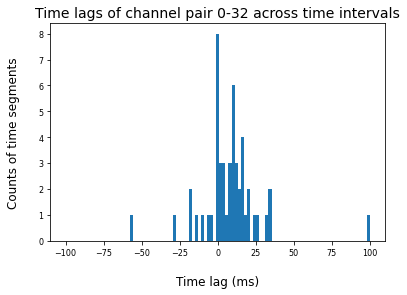

<Figure size 720x1152 with 0 Axes>

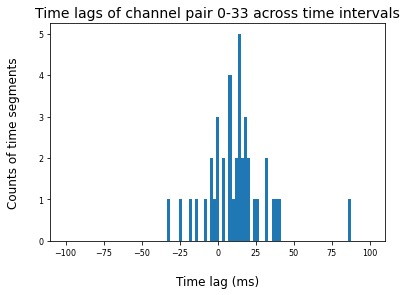

<Figure size 720x1152 with 0 Axes>

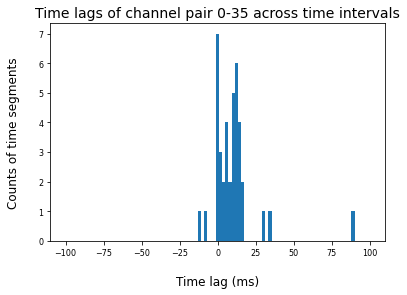

<Figure size 720x1152 with 0 Axes>

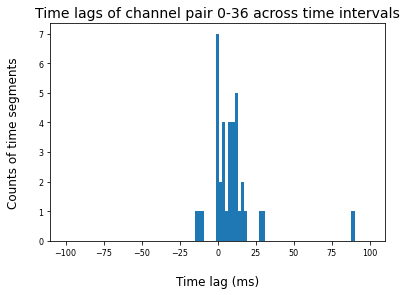

<Figure size 720x1152 with 0 Axes>

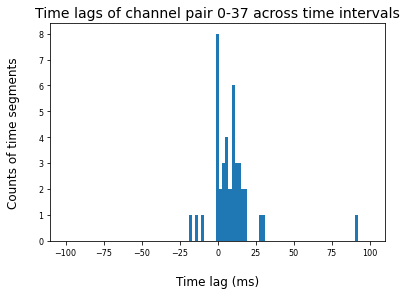

<Figure size 720x1152 with 0 Axes>

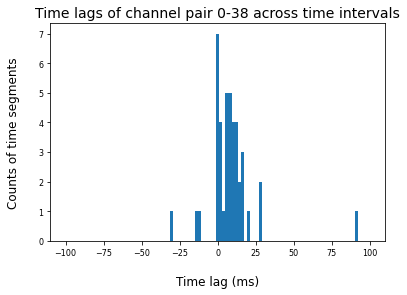

<Figure size 720x1152 with 0 Axes>

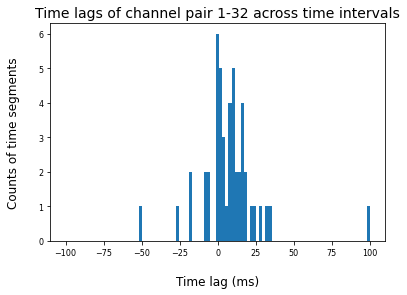

<Figure size 720x1152 with 0 Axes>

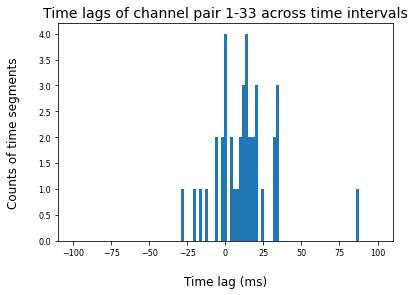

<Figure size 720x1152 with 0 Axes>

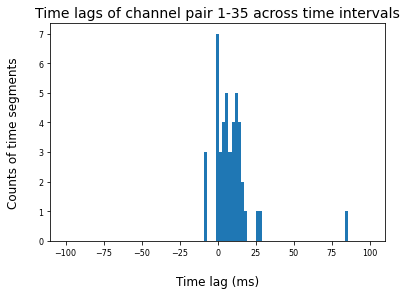

<Figure size 720x1152 with 0 Axes>

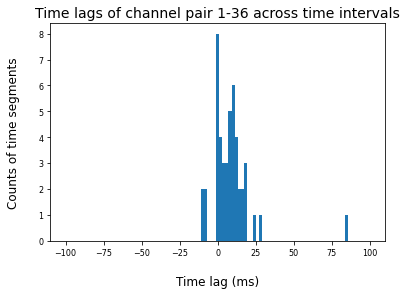

<Figure size 720x1152 with 0 Axes>

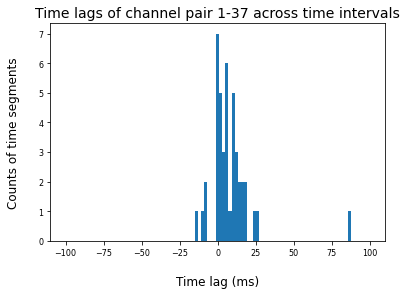

<Figure size 720x1152 with 0 Axes>

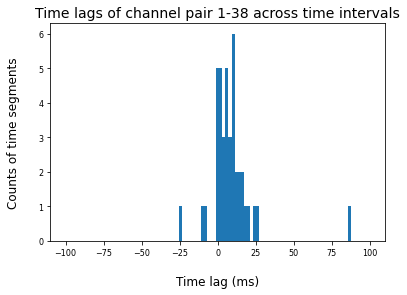

<Figure size 720x1152 with 0 Axes>

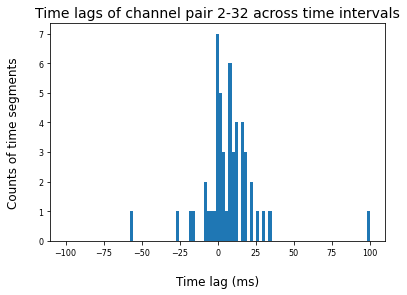

<Figure size 720x1152 with 0 Axes>

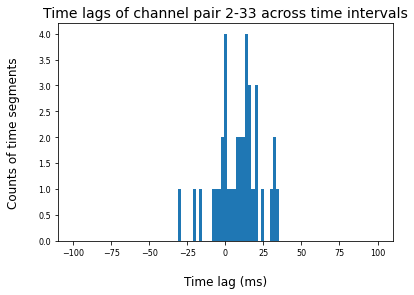

<Figure size 720x1152 with 0 Axes>

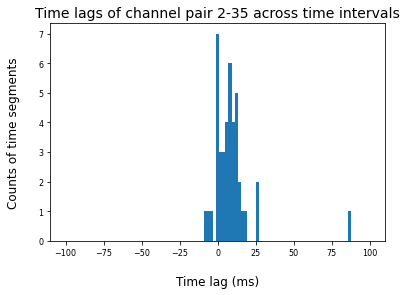

<Figure size 720x1152 with 0 Axes>

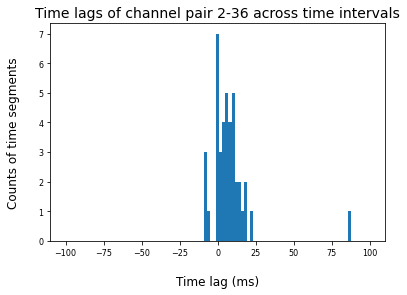

<Figure size 720x1152 with 0 Axes>

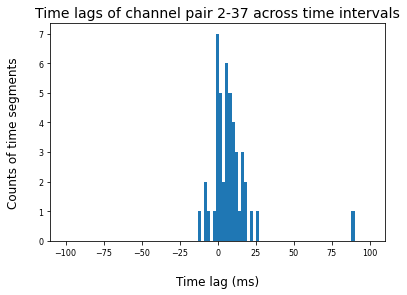

<Figure size 720x1152 with 0 Axes>

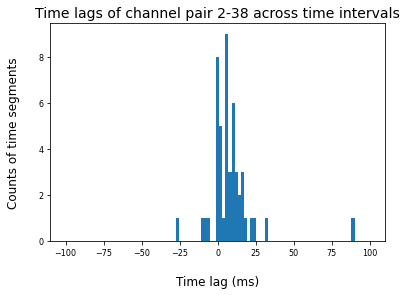

<Figure size 720x1152 with 0 Axes>

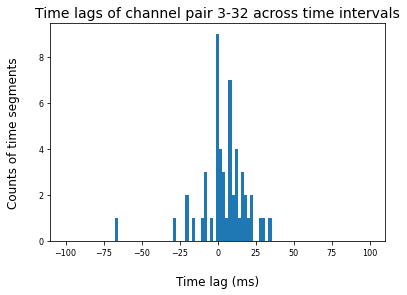

<Figure size 720x1152 with 0 Axes>

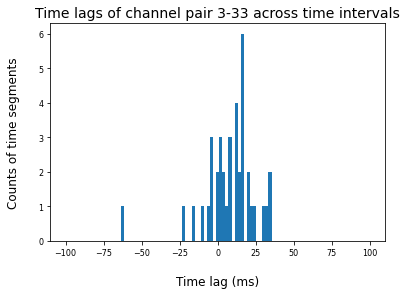

<Figure size 720x1152 with 0 Axes>

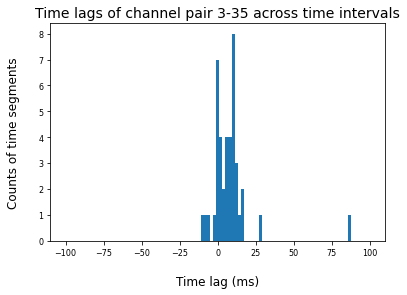

<Figure size 720x1152 with 0 Axes>

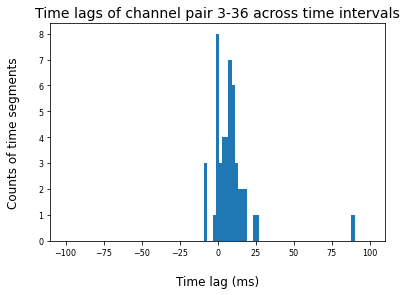

<Figure size 720x1152 with 0 Axes>

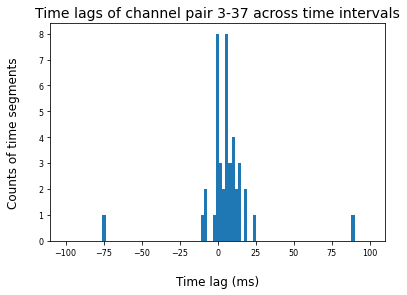

<Figure size 720x1152 with 0 Axes>

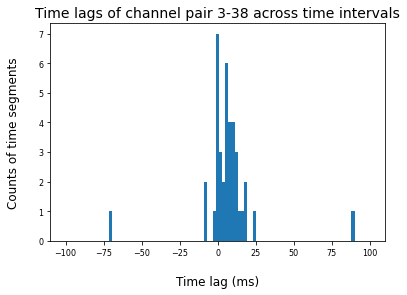

<Figure size 720x1152 with 0 Axes>

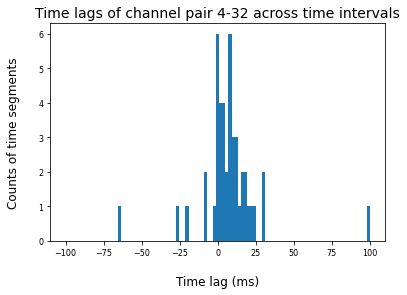

<Figure size 720x1152 with 0 Axes>

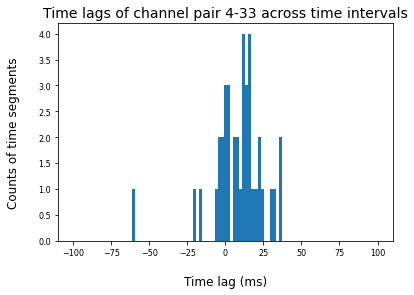

<Figure size 720x1152 with 0 Axes>

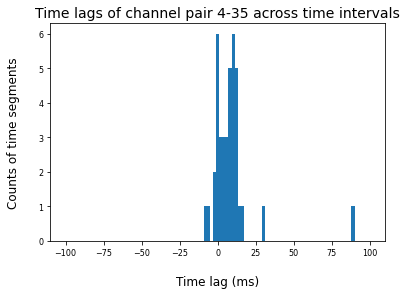

<Figure size 720x1152 with 0 Axes>

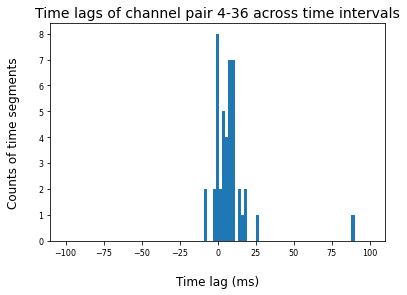

<Figure size 720x1152 with 0 Axes>

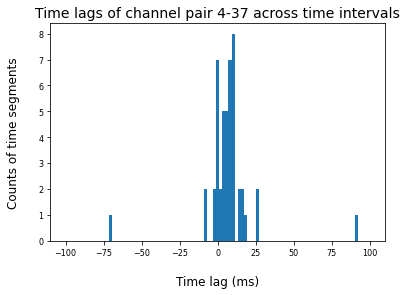

<Figure size 720x1152 with 0 Axes>

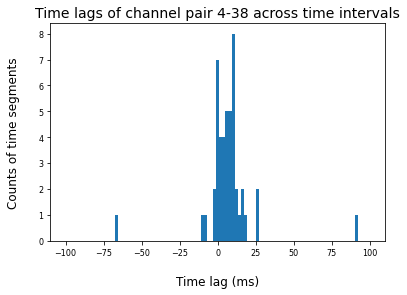

<Figure size 720x1152 with 0 Axes>

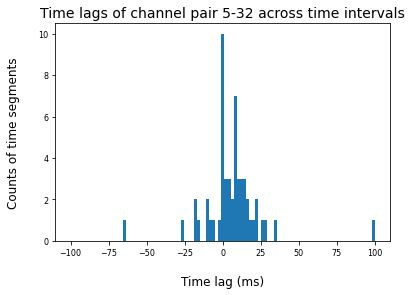

<Figure size 720x1152 with 0 Axes>

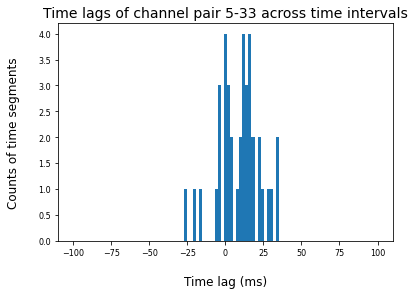

<Figure size 720x1152 with 0 Axes>

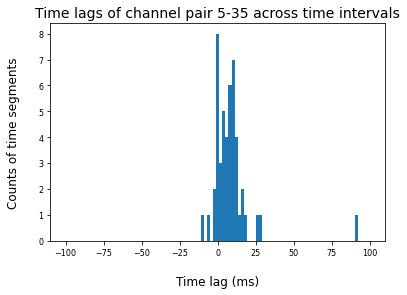

<Figure size 720x1152 with 0 Axes>

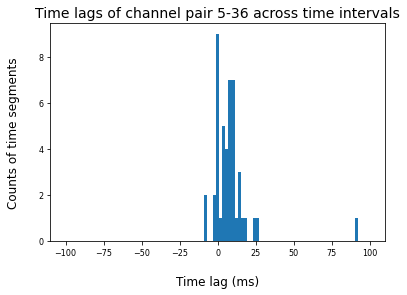

<Figure size 720x1152 with 0 Axes>

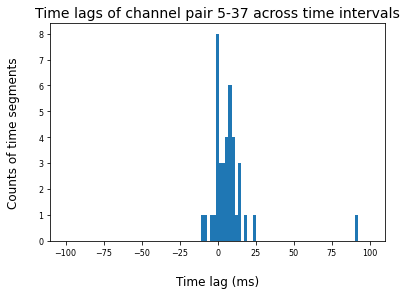

<Figure size 720x1152 with 0 Axes>

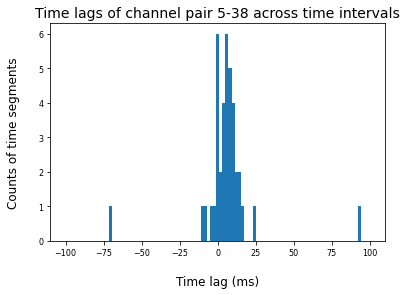

<Figure size 720x1152 with 0 Axes>

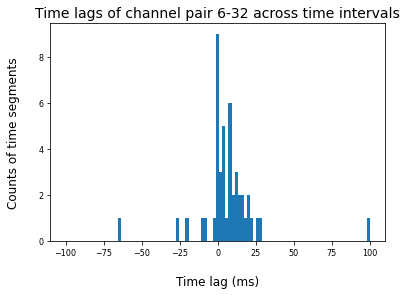

<Figure size 720x1152 with 0 Axes>

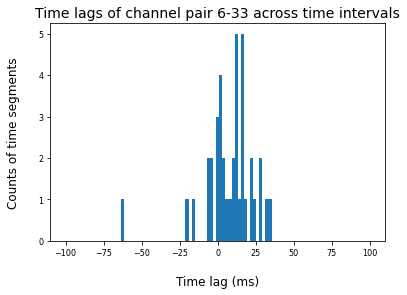

<Figure size 720x1152 with 0 Axes>

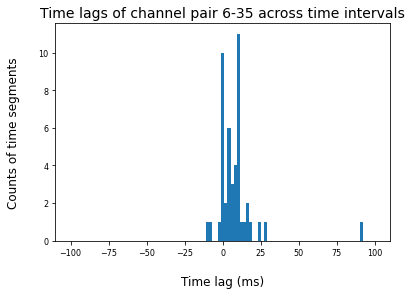

<Figure size 720x1152 with 0 Axes>

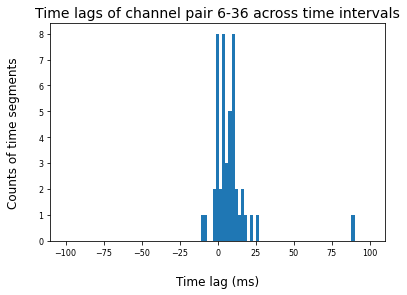

<Figure size 720x1152 with 0 Axes>

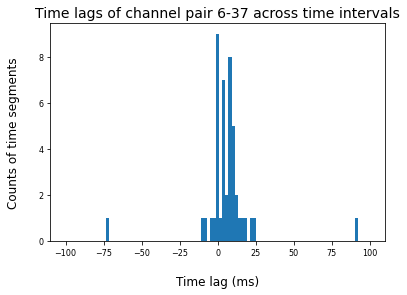

<Figure size 720x1152 with 0 Axes>

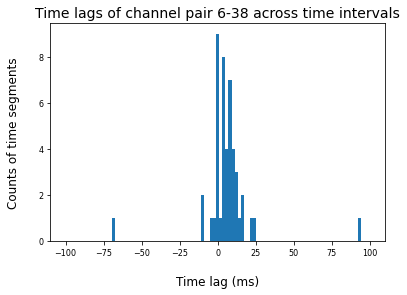

<Figure size 720x1152 with 0 Axes>

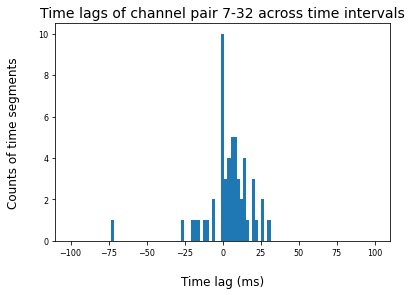

<Figure size 720x1152 with 0 Axes>

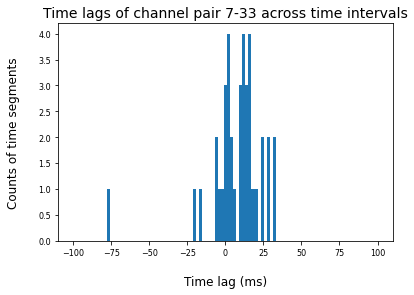

<Figure size 720x1152 with 0 Axes>

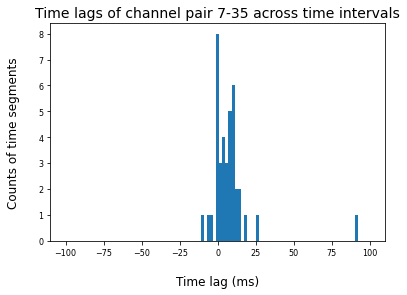

<Figure size 720x1152 with 0 Axes>

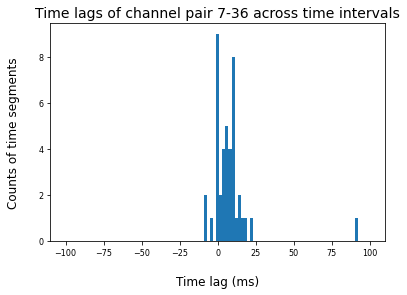

<Figure size 720x1152 with 0 Axes>

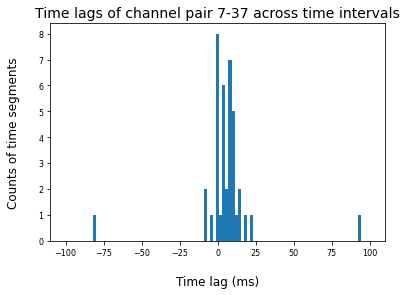

<Figure size 720x1152 with 0 Axes>

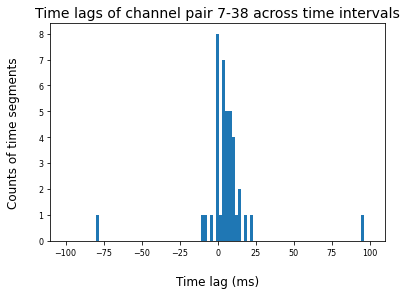

<Figure size 720x1152 with 0 Axes>

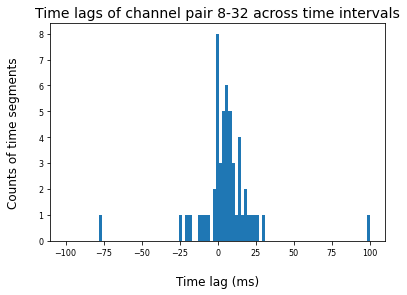

<Figure size 720x1152 with 0 Axes>

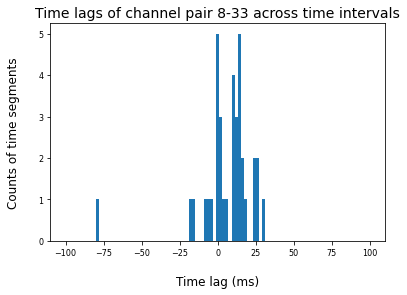

<Figure size 720x1152 with 0 Axes>

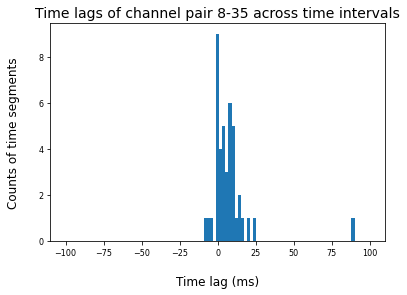

<Figure size 720x1152 with 0 Axes>

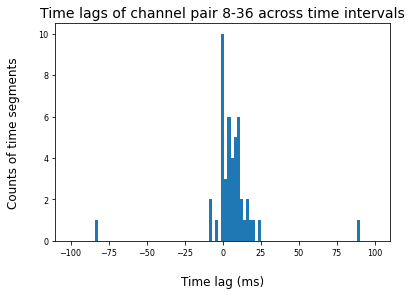

<Figure size 720x1152 with 0 Axes>

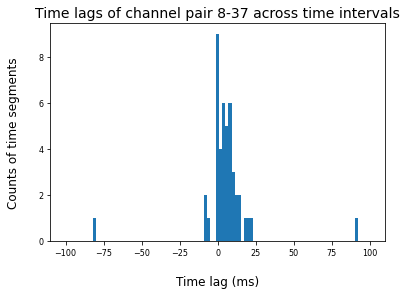

<Figure size 720x1152 with 0 Axes>

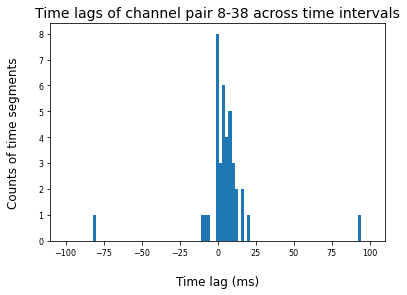

<Figure size 720x1152 with 0 Axes>

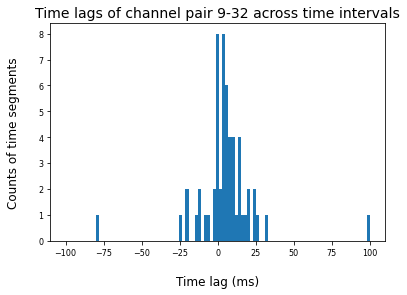

<Figure size 720x1152 with 0 Axes>

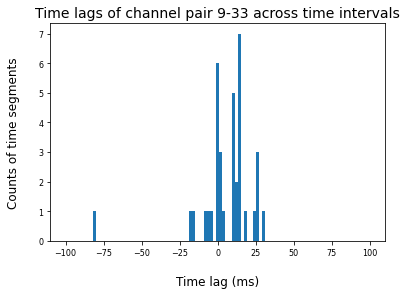

<Figure size 720x1152 with 0 Axes>

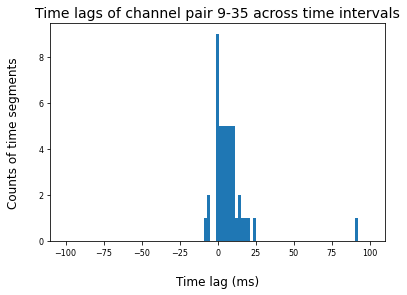

<Figure size 720x1152 with 0 Axes>

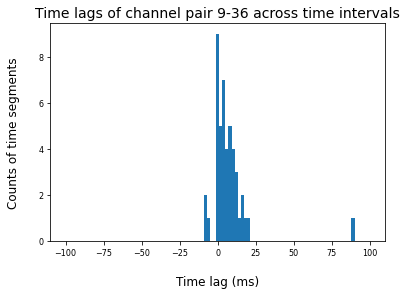

<Figure size 720x1152 with 0 Axes>

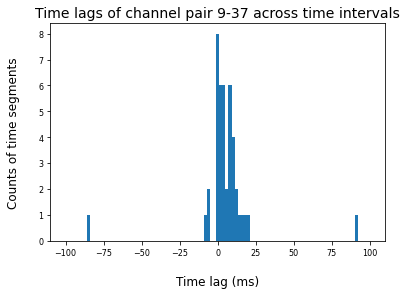

<Figure size 720x1152 with 0 Axes>

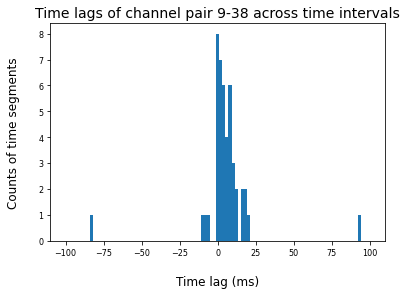

<Figure size 720x1152 with 0 Axes>

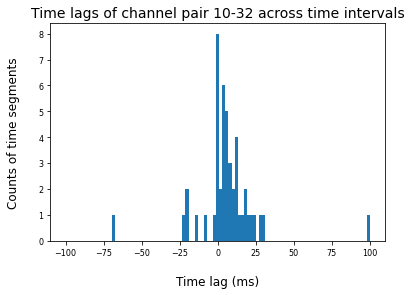

<Figure size 720x1152 with 0 Axes>

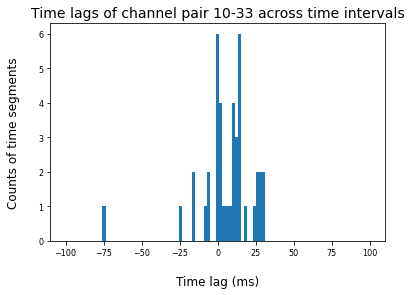

<Figure size 720x1152 with 0 Axes>

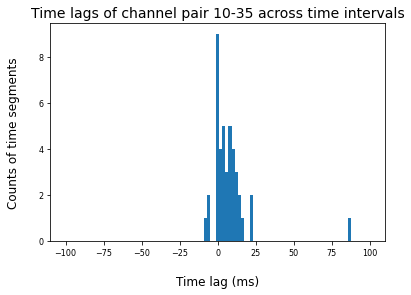

<Figure size 720x1152 with 0 Axes>

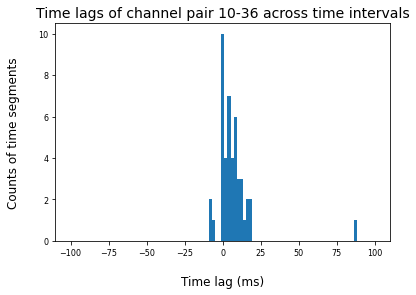

<Figure size 720x1152 with 0 Axes>

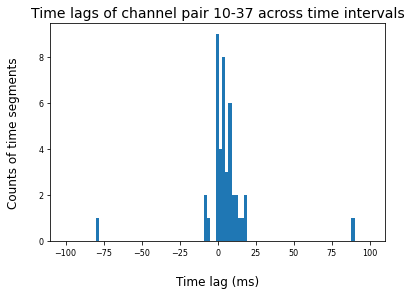

<Figure size 720x1152 with 0 Axes>

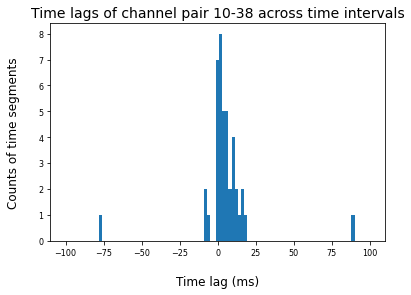

<Figure size 720x1152 with 0 Axes>

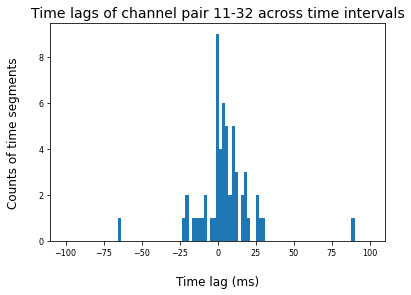

<Figure size 720x1152 with 0 Axes>

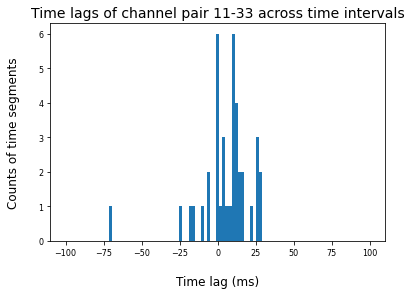

<Figure size 720x1152 with 0 Axes>

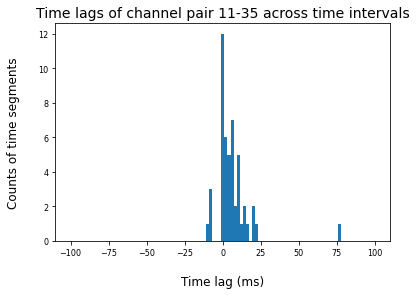

<Figure size 720x1152 with 0 Axes>

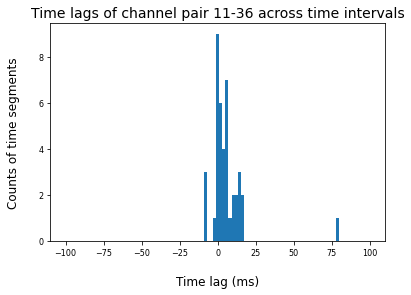

<Figure size 720x1152 with 0 Axes>

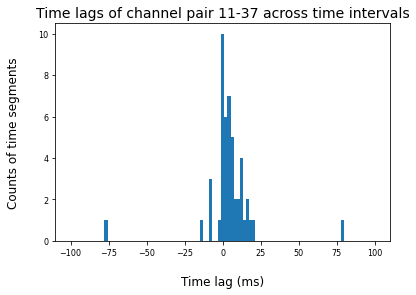

<Figure size 720x1152 with 0 Axes>

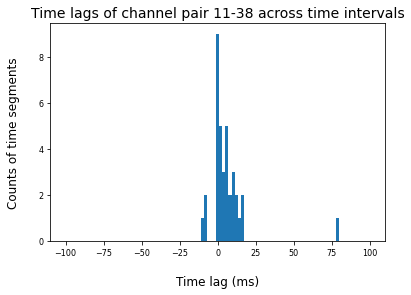

<Figure size 720x1152 with 0 Axes>

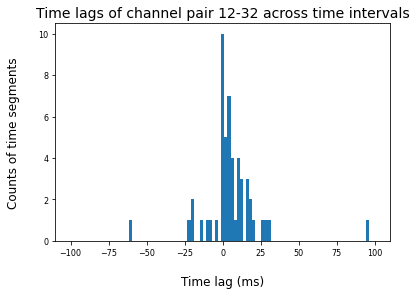

<Figure size 720x1152 with 0 Axes>

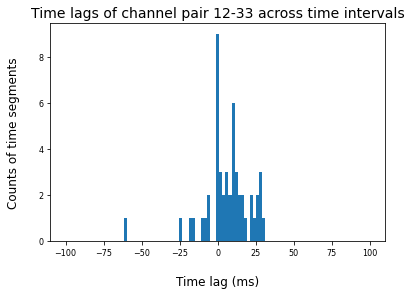

<Figure size 720x1152 with 0 Axes>

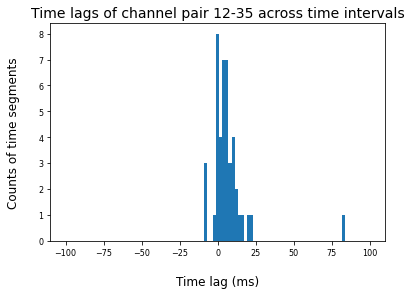

<Figure size 720x1152 with 0 Axes>

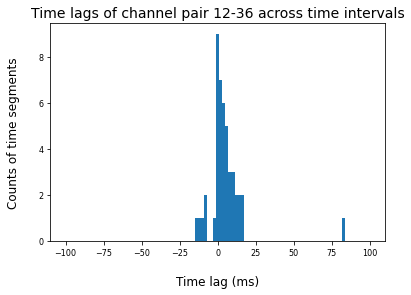

<Figure size 720x1152 with 0 Axes>

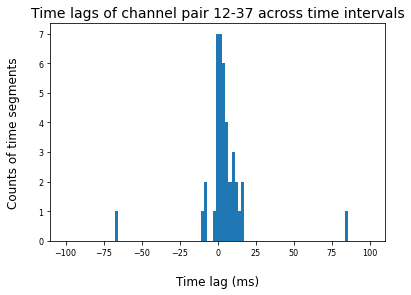

<Figure size 720x1152 with 0 Axes>

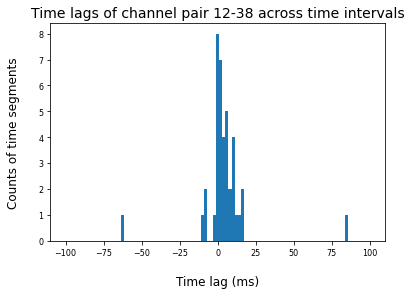

<Figure size 720x1152 with 0 Axes>

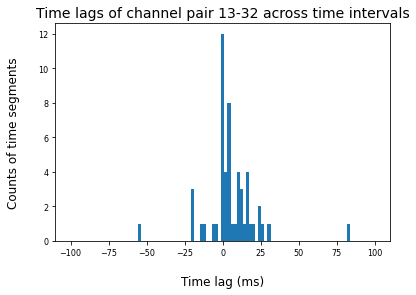

<Figure size 720x1152 with 0 Axes>

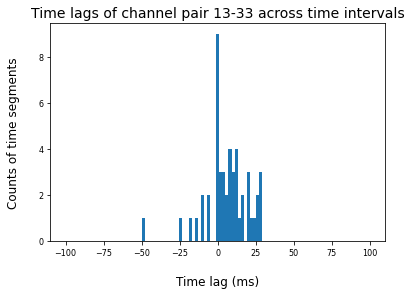

<Figure size 720x1152 with 0 Axes>

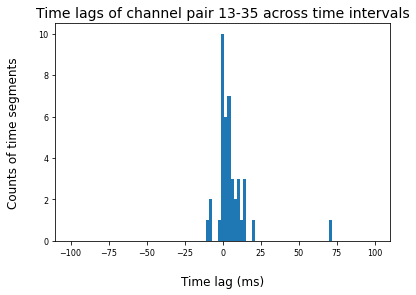

<Figure size 720x1152 with 0 Axes>

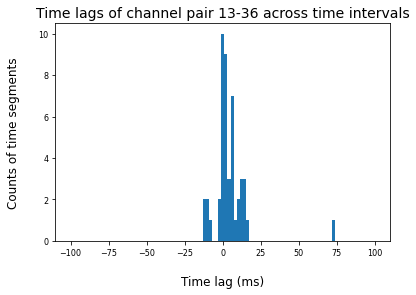

<Figure size 720x1152 with 0 Axes>

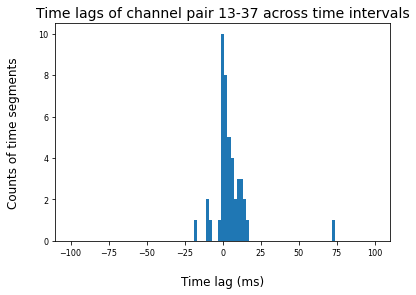

<Figure size 720x1152 with 0 Axes>

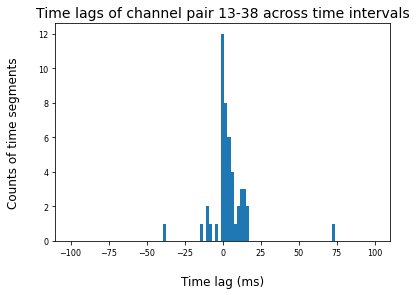

<Figure size 720x1152 with 0 Axes>

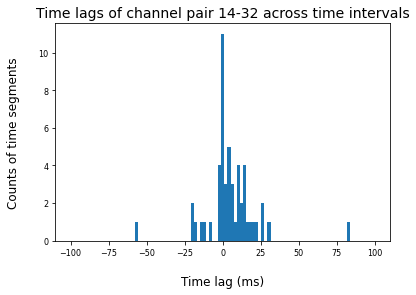

<Figure size 720x1152 with 0 Axes>

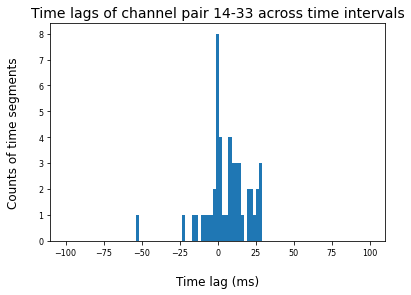

<Figure size 720x1152 with 0 Axes>

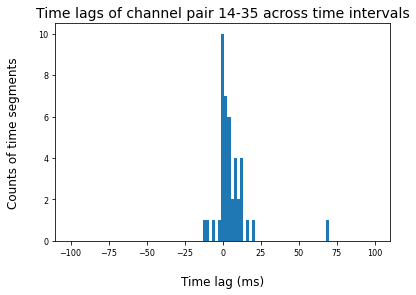

<Figure size 720x1152 with 0 Axes>

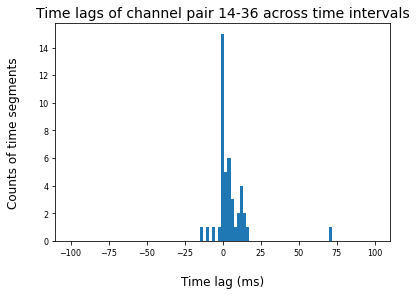

<Figure size 720x1152 with 0 Axes>

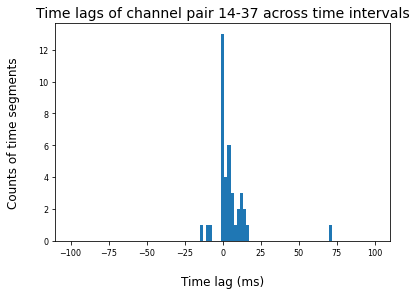

<Figure size 720x1152 with 0 Axes>

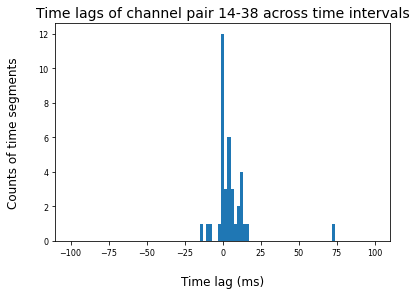

<Figure size 720x1152 with 0 Axes>

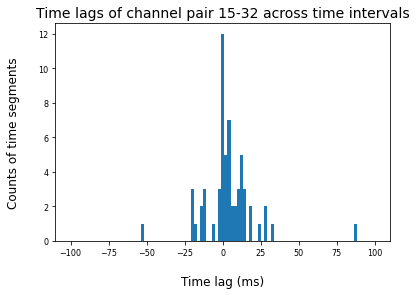

<Figure size 720x1152 with 0 Axes>

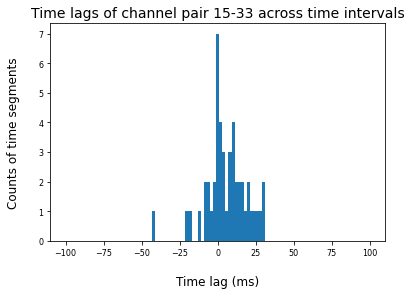

<Figure size 720x1152 with 0 Axes>

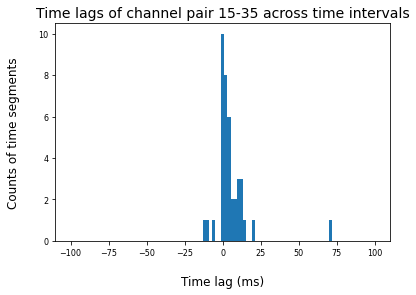

<Figure size 720x1152 with 0 Axes>

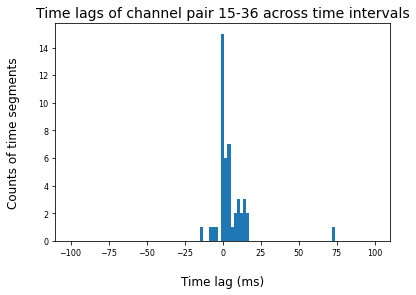

<Figure size 720x1152 with 0 Axes>

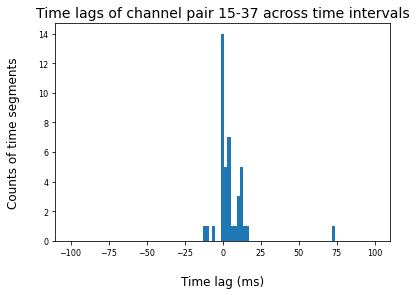

<Figure size 720x1152 with 0 Axes>

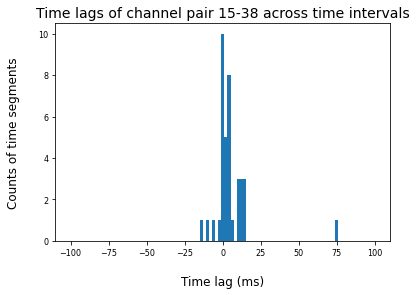

<Figure size 720x1152 with 0 Axes>

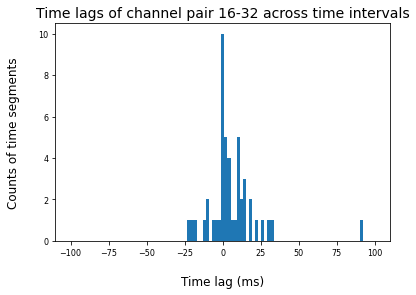

<Figure size 720x1152 with 0 Axes>

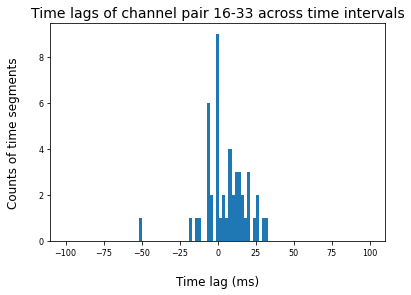

<Figure size 720x1152 with 0 Axes>

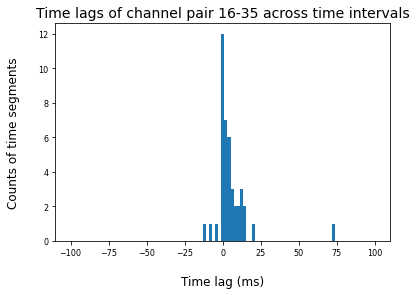

<Figure size 720x1152 with 0 Axes>

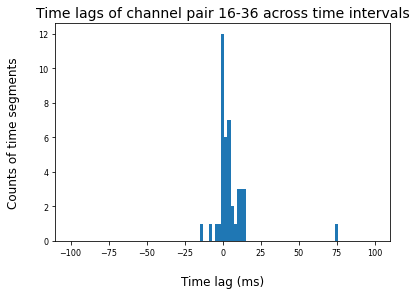

<Figure size 720x1152 with 0 Axes>

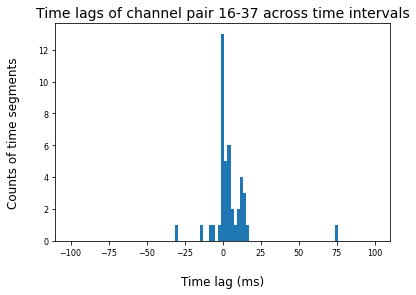

<Figure size 720x1152 with 0 Axes>

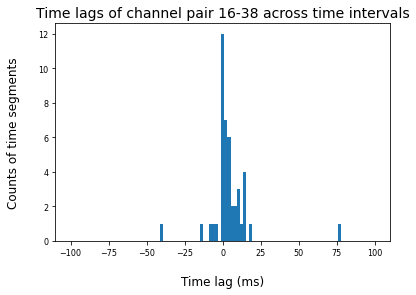

<Figure size 720x1152 with 0 Axes>

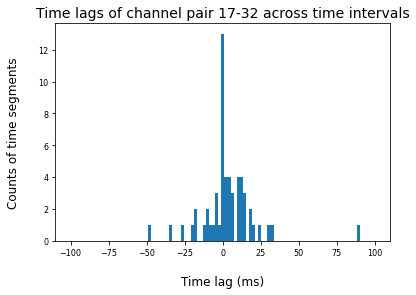

<Figure size 720x1152 with 0 Axes>

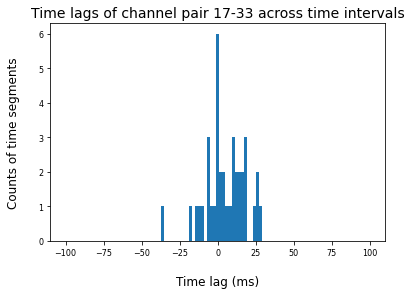

<Figure size 720x1152 with 0 Axes>

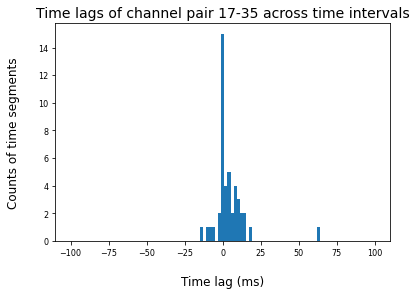

<Figure size 720x1152 with 0 Axes>

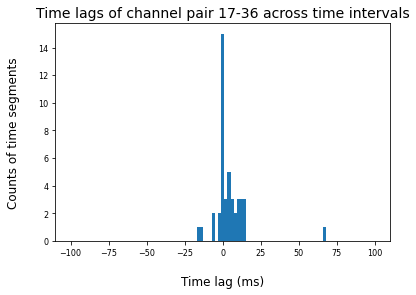

<Figure size 720x1152 with 0 Axes>

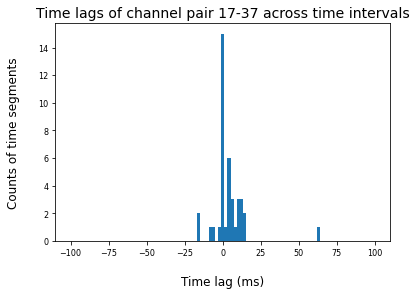

<Figure size 720x1152 with 0 Axes>

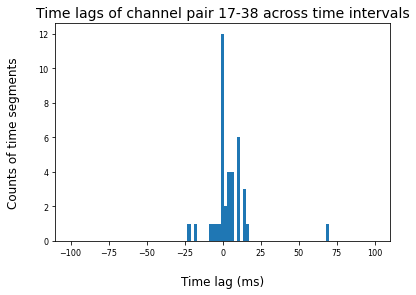

<Figure size 720x1152 with 0 Axes>

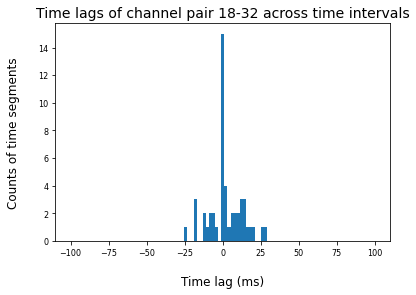

<Figure size 720x1152 with 0 Axes>

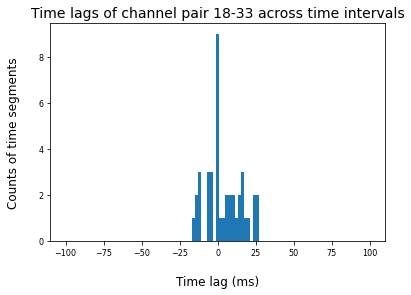

<Figure size 720x1152 with 0 Axes>

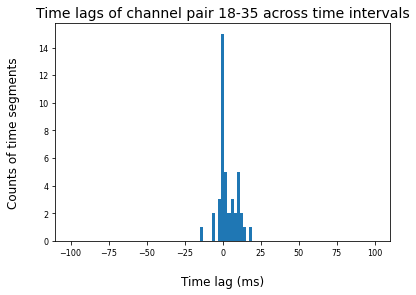

<Figure size 720x1152 with 0 Axes>

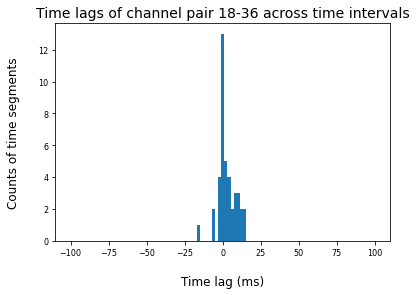

<Figure size 720x1152 with 0 Axes>

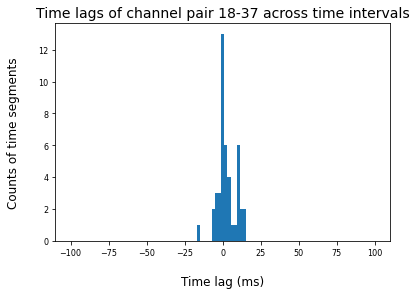

<Figure size 720x1152 with 0 Axes>

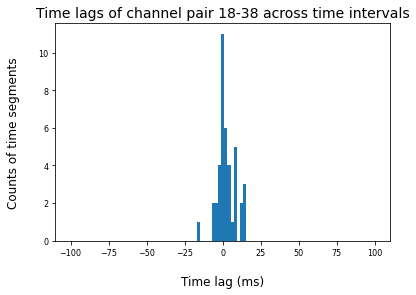

<Figure size 720x1152 with 0 Axes>

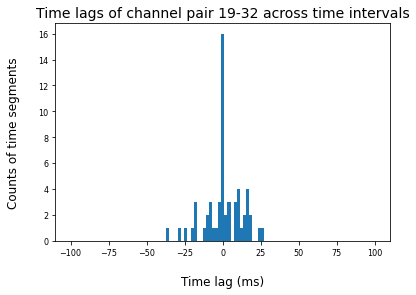

<Figure size 720x1152 with 0 Axes>

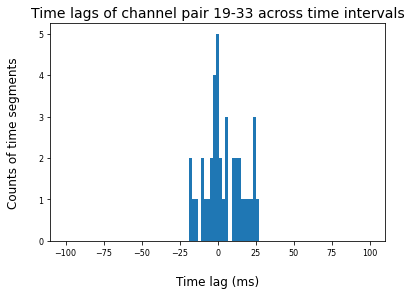

<Figure size 720x1152 with 0 Axes>

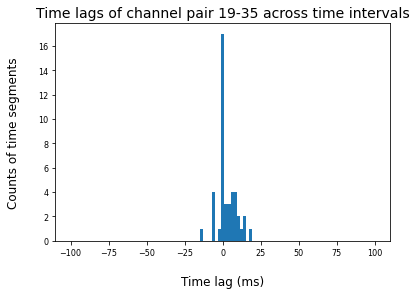

<Figure size 720x1152 with 0 Axes>

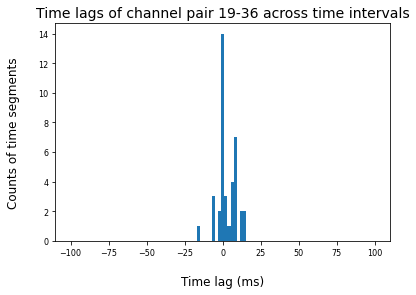

<Figure size 720x1152 with 0 Axes>

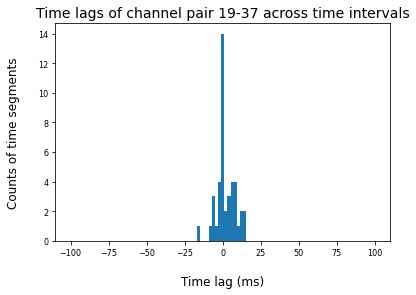

<Figure size 720x1152 with 0 Axes>

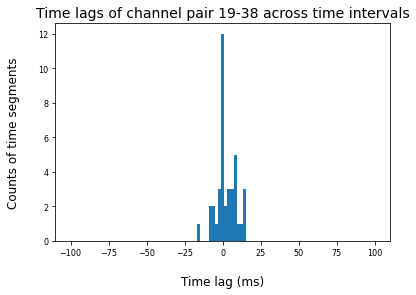

<Figure size 720x1152 with 0 Axes>

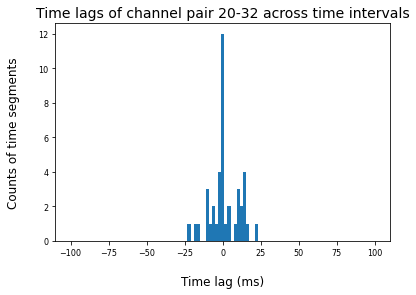

<Figure size 720x1152 with 0 Axes>

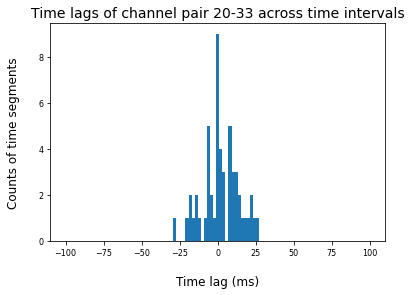

<Figure size 720x1152 with 0 Axes>

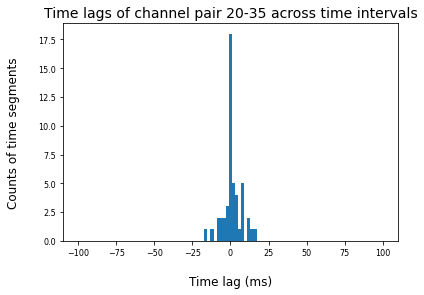

<Figure size 720x1152 with 0 Axes>

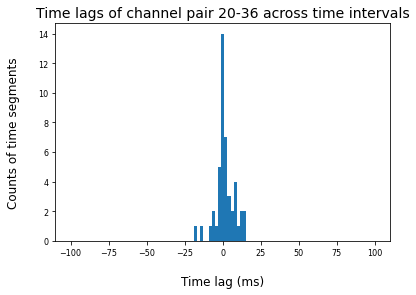

<Figure size 720x1152 with 0 Axes>

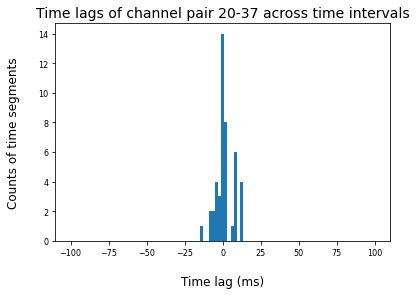

<Figure size 720x1152 with 0 Axes>

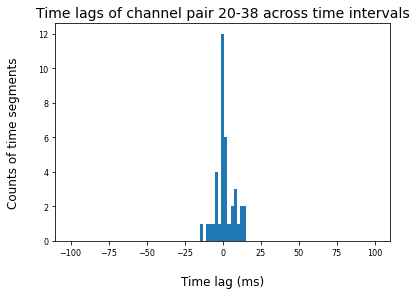

<Figure size 720x1152 with 0 Axes>

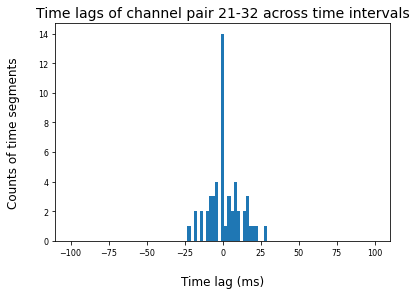

<Figure size 720x1152 with 0 Axes>

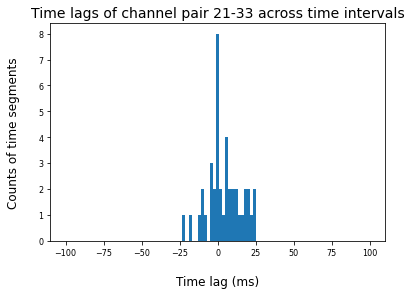

<Figure size 720x1152 with 0 Axes>

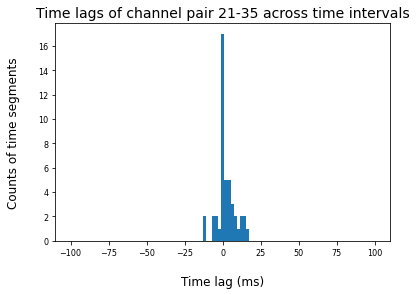

<Figure size 720x1152 with 0 Axes>

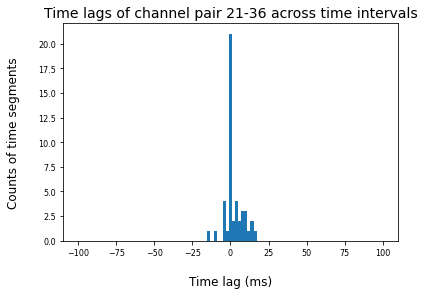

<Figure size 720x1152 with 0 Axes>

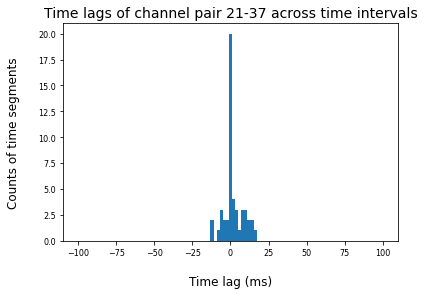

<Figure size 720x1152 with 0 Axes>

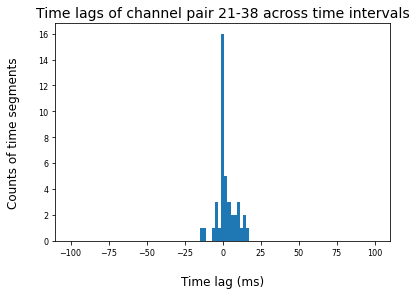

<Figure size 720x1152 with 0 Axes>

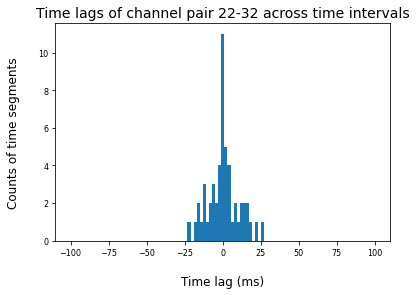

<Figure size 720x1152 with 0 Axes>

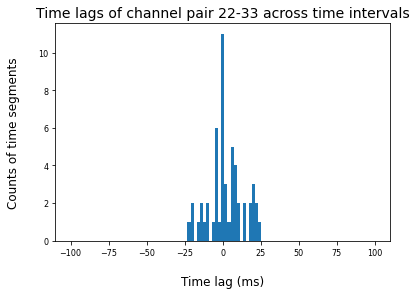

<Figure size 720x1152 with 0 Axes>

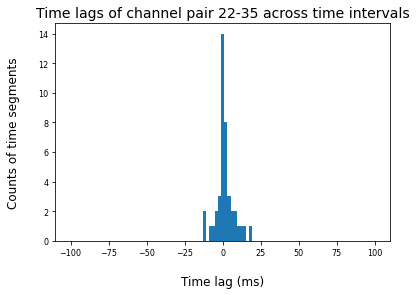

<Figure size 720x1152 with 0 Axes>

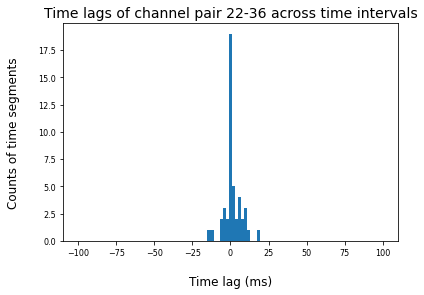

<Figure size 720x1152 with 0 Axes>

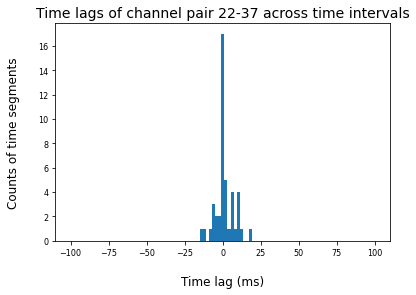

<Figure size 720x1152 with 0 Axes>

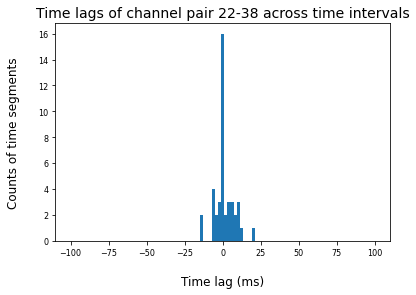

<Figure size 720x1152 with 0 Axes>

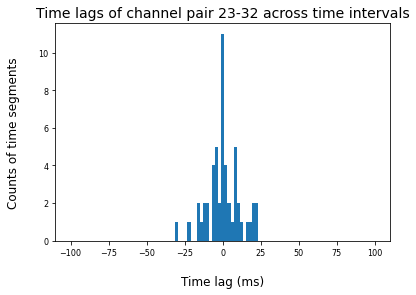

<Figure size 720x1152 with 0 Axes>

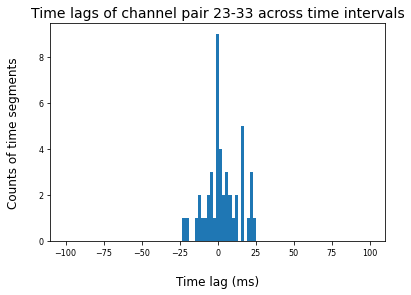

<Figure size 720x1152 with 0 Axes>

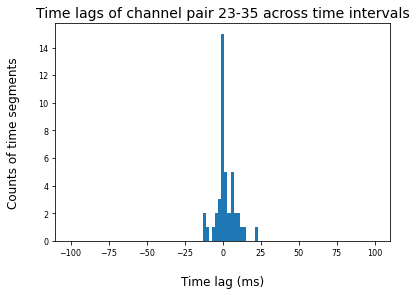

<Figure size 720x1152 with 0 Axes>

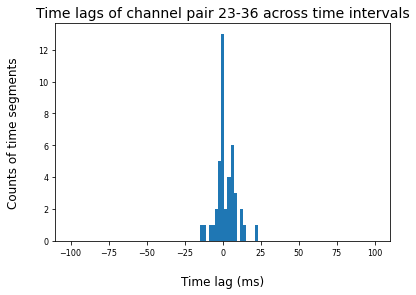

<Figure size 720x1152 with 0 Axes>

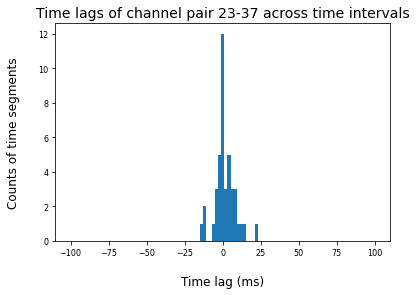

<Figure size 720x1152 with 0 Axes>

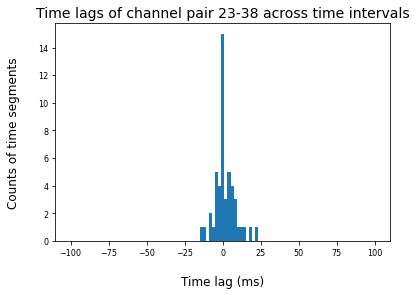

<Figure size 720x1152 with 0 Axes>

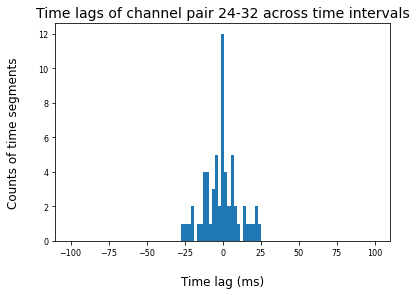

<Figure size 720x1152 with 0 Axes>

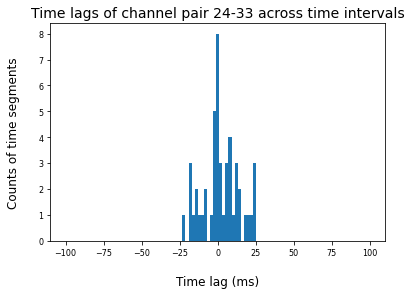

<Figure size 720x1152 with 0 Axes>

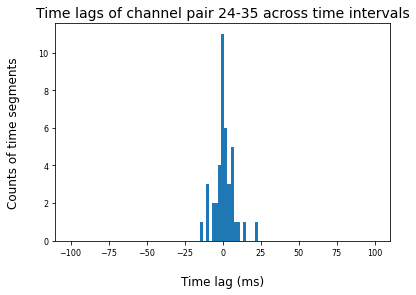

<Figure size 720x1152 with 0 Axes>

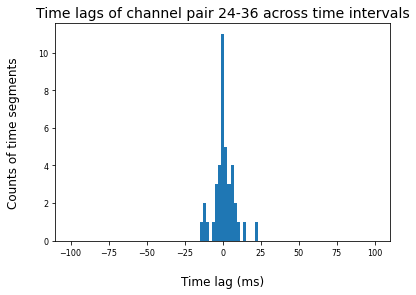

<Figure size 720x1152 with 0 Axes>

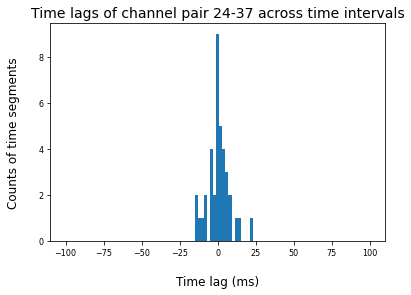

<Figure size 720x1152 with 0 Axes>

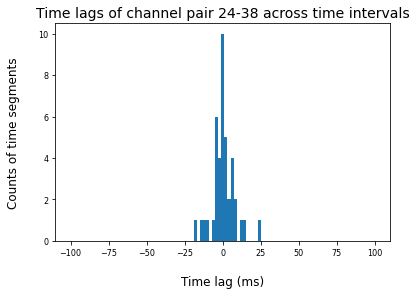

<Figure size 720x1152 with 0 Axes>

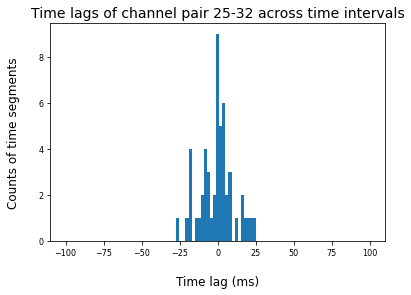

<Figure size 720x1152 with 0 Axes>

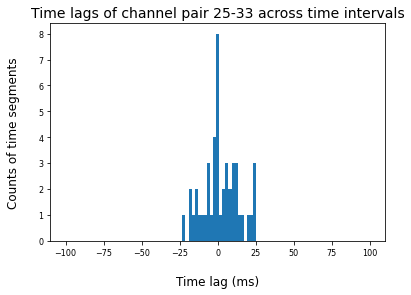

<Figure size 720x1152 with 0 Axes>

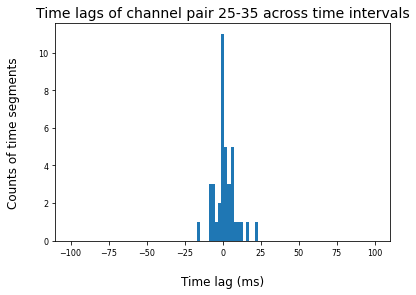

<Figure size 720x1152 with 0 Axes>

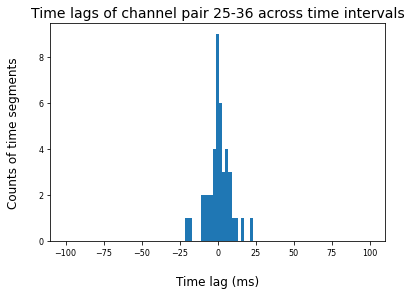

<Figure size 720x1152 with 0 Axes>

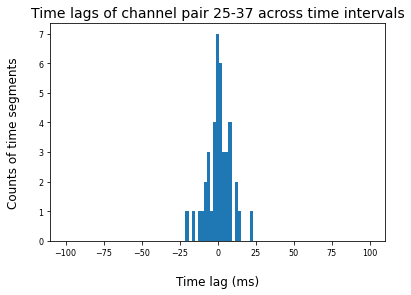

<Figure size 720x1152 with 0 Axes>

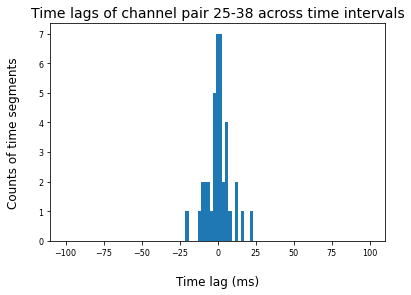

<Figure size 720x1152 with 0 Axes>

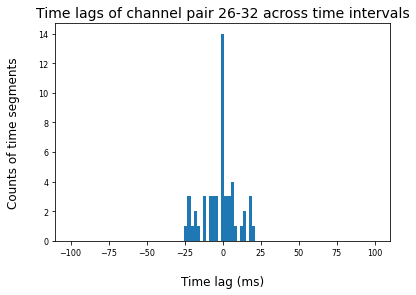

<Figure size 720x1152 with 0 Axes>

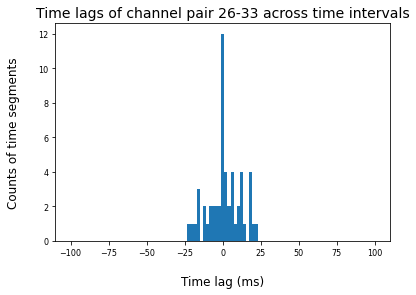

<Figure size 720x1152 with 0 Axes>

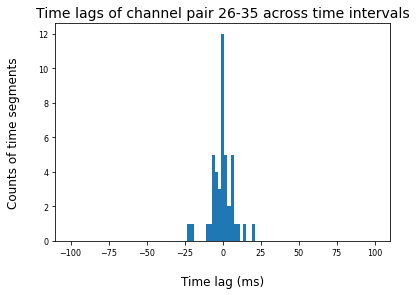

<Figure size 720x1152 with 0 Axes>

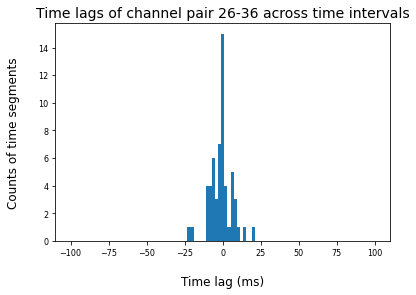

<Figure size 720x1152 with 0 Axes>

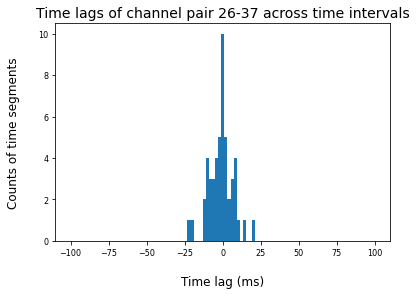

<Figure size 720x1152 with 0 Axes>

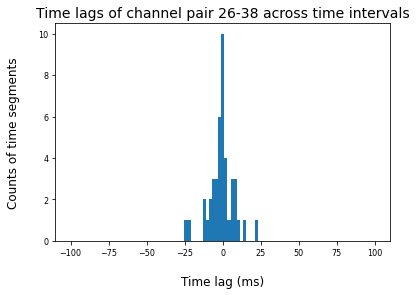

<Figure size 720x1152 with 0 Axes>

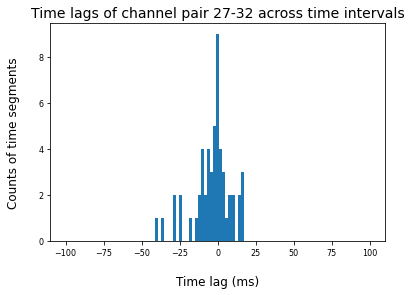

<Figure size 720x1152 with 0 Axes>

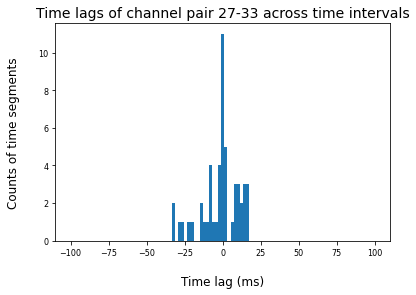

<Figure size 720x1152 with 0 Axes>

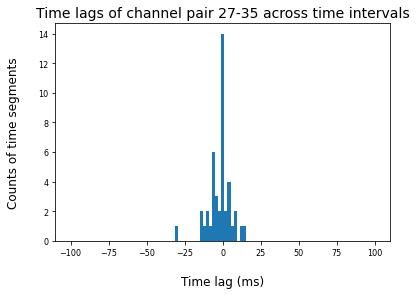

<Figure size 720x1152 with 0 Axes>

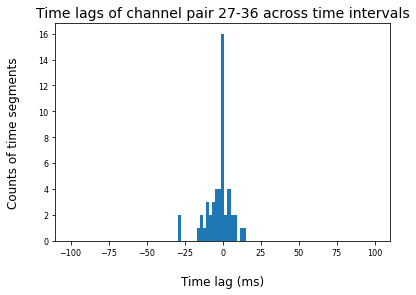

<Figure size 720x1152 with 0 Axes>

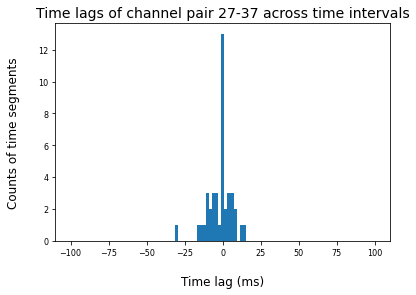

<Figure size 720x1152 with 0 Axes>

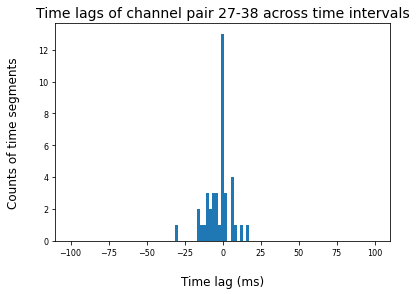

<Figure size 720x1152 with 0 Axes>

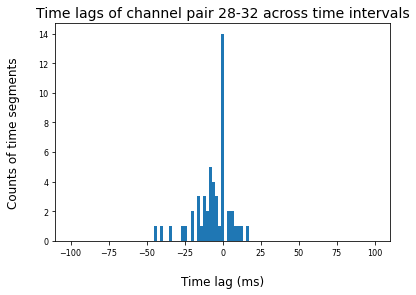

<Figure size 720x1152 with 0 Axes>

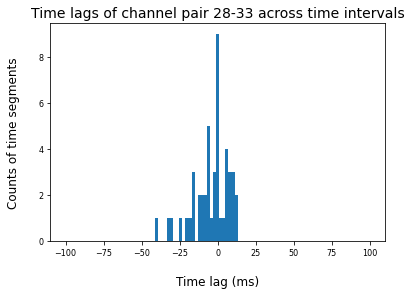

<Figure size 720x1152 with 0 Axes>

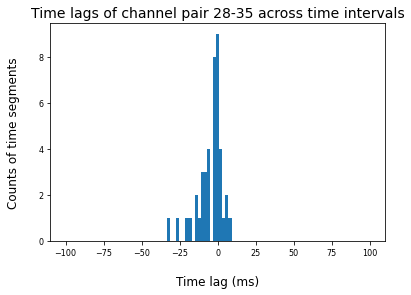

<Figure size 720x1152 with 0 Axes>

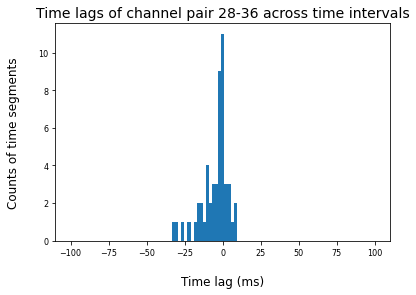

<Figure size 720x1152 with 0 Axes>

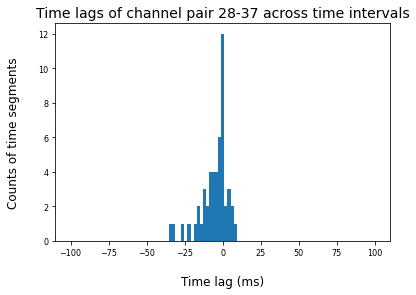

<Figure size 720x1152 with 0 Axes>

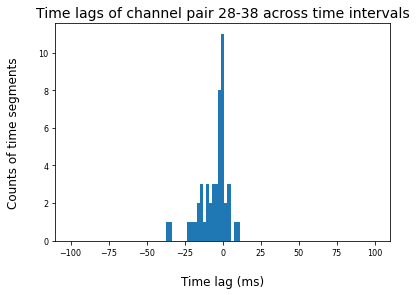

<Figure size 720x1152 with 0 Axes>

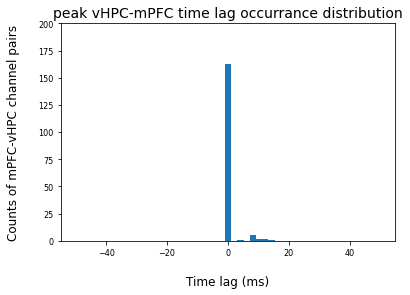

<Figure size 720x1152 with 0 Axes>

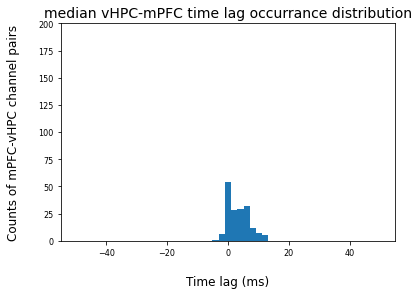

<Figure size 720x1152 with 0 Axes>

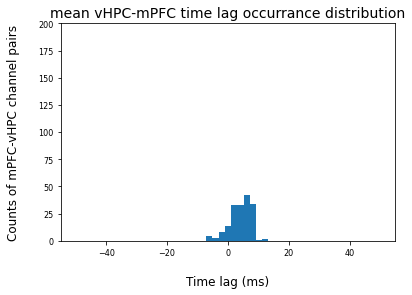

<Figure size 720x1152 with 0 Axes>

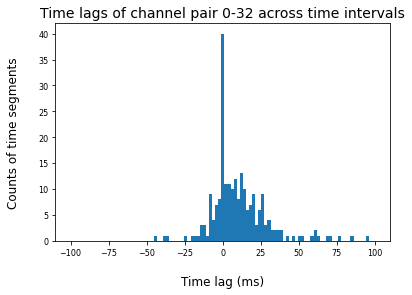

<Figure size 720x1152 with 0 Axes>

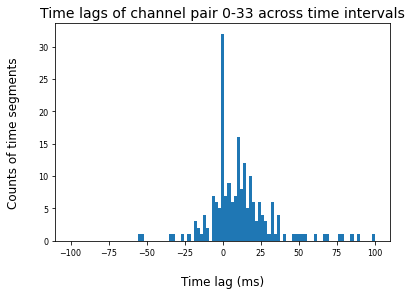

<Figure size 720x1152 with 0 Axes>

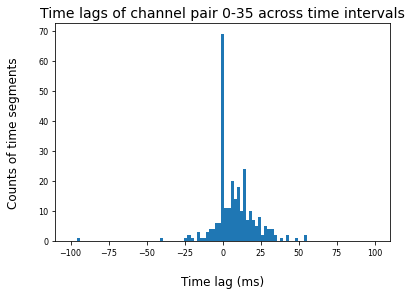

<Figure size 720x1152 with 0 Axes>

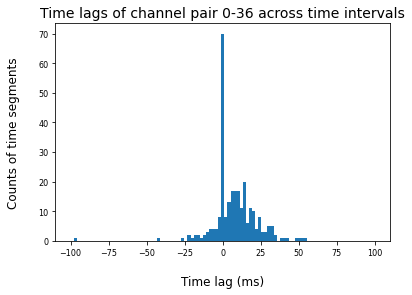

<Figure size 720x1152 with 0 Axes>

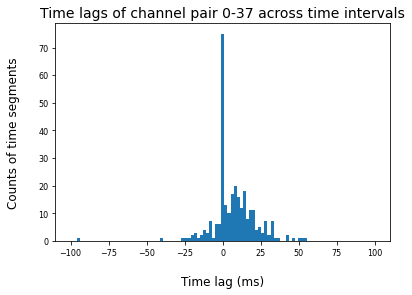

<Figure size 720x1152 with 0 Axes>

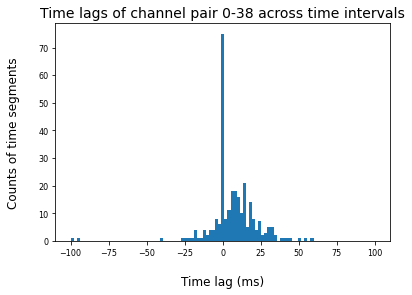

<Figure size 720x1152 with 0 Axes>

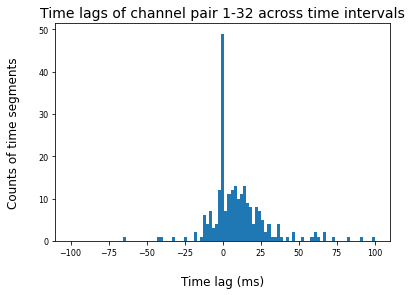

<Figure size 720x1152 with 0 Axes>

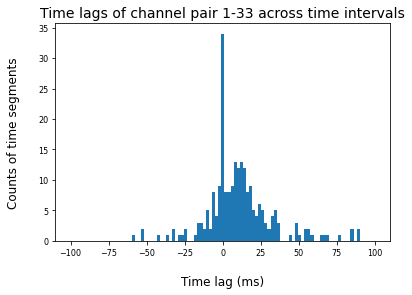

<Figure size 720x1152 with 0 Axes>

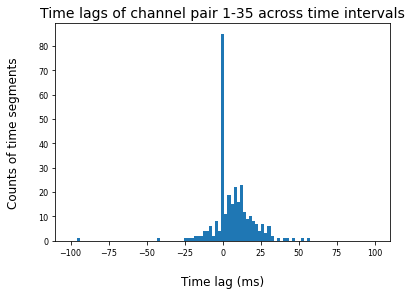

<Figure size 720x1152 with 0 Axes>

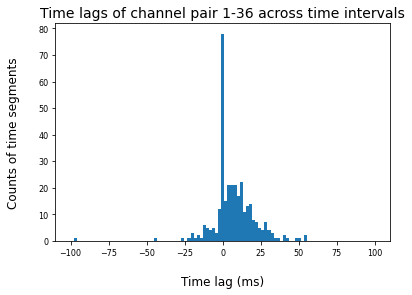

<Figure size 720x1152 with 0 Axes>

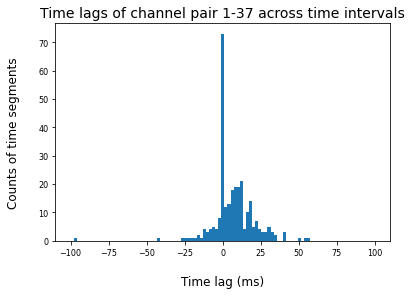

<Figure size 720x1152 with 0 Axes>

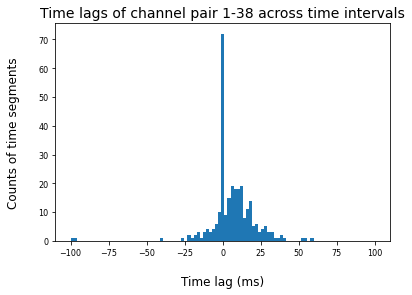

<Figure size 720x1152 with 0 Axes>

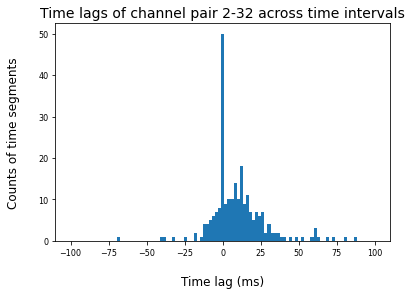

<Figure size 720x1152 with 0 Axes>

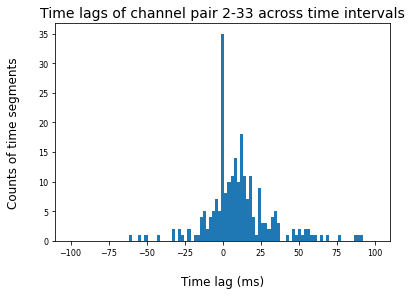

<Figure size 720x1152 with 0 Axes>

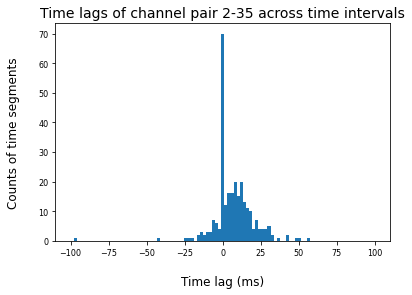

<Figure size 720x1152 with 0 Axes>

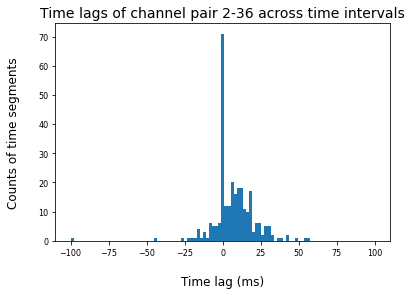

<Figure size 720x1152 with 0 Axes>

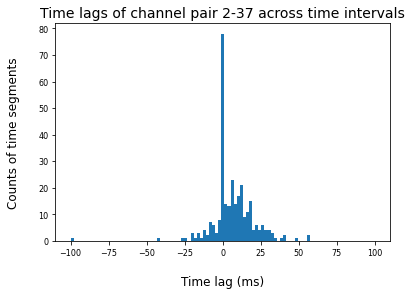

<Figure size 720x1152 with 0 Axes>

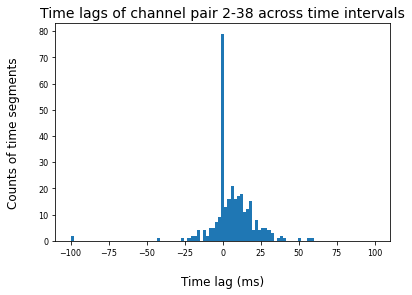

<Figure size 720x1152 with 0 Axes>

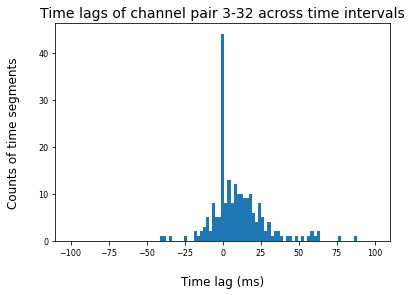

<Figure size 720x1152 with 0 Axes>

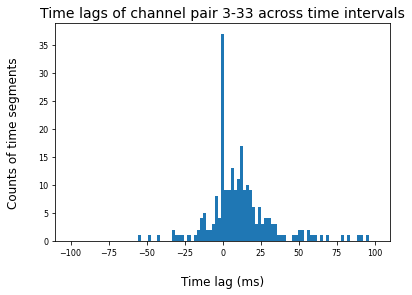

<Figure size 720x1152 with 0 Axes>

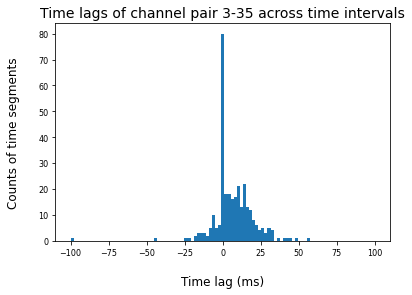

<Figure size 720x1152 with 0 Axes>

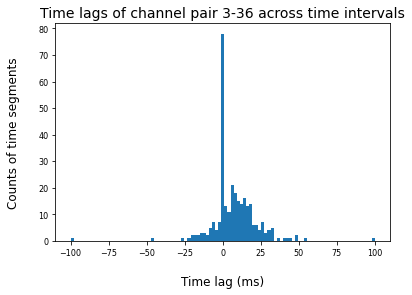

<Figure size 720x1152 with 0 Axes>

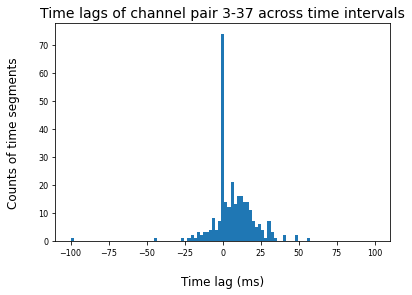

<Figure size 720x1152 with 0 Axes>

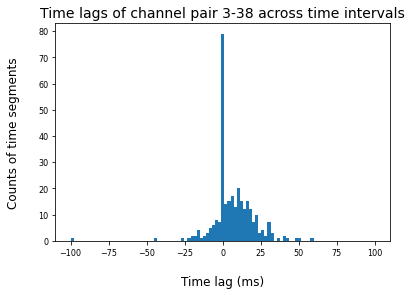

<Figure size 720x1152 with 0 Axes>

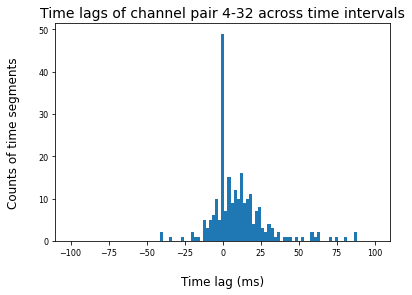

<Figure size 720x1152 with 0 Axes>

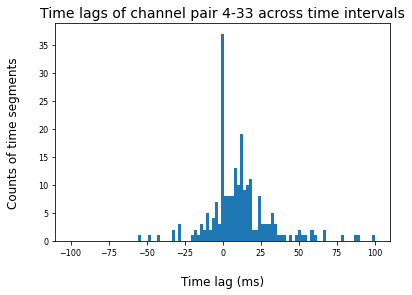

<Figure size 720x1152 with 0 Axes>

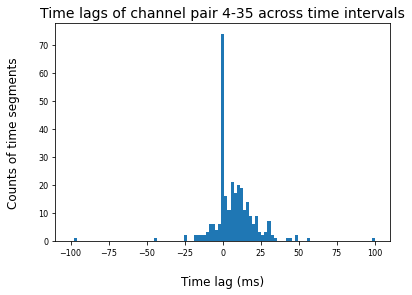

<Figure size 720x1152 with 0 Axes>

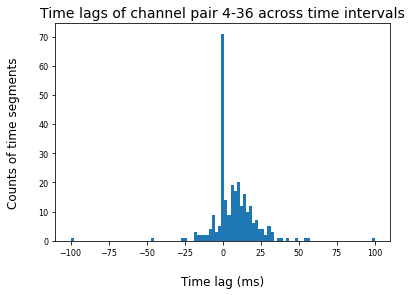

<Figure size 720x1152 with 0 Axes>

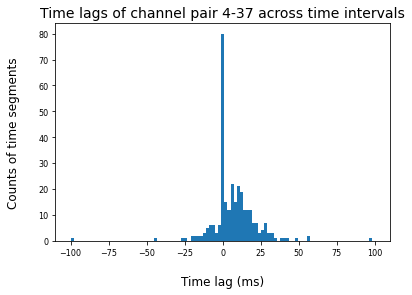

<Figure size 720x1152 with 0 Axes>

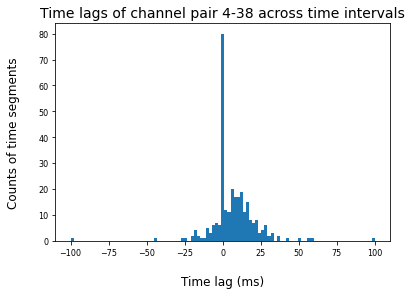

<Figure size 720x1152 with 0 Axes>

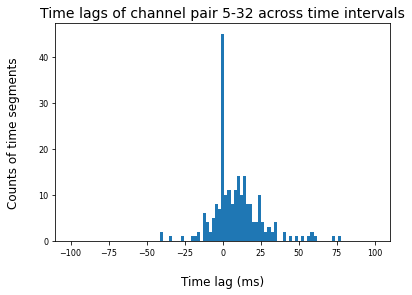

<Figure size 720x1152 with 0 Axes>

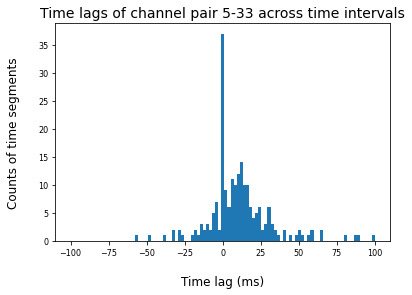

<Figure size 720x1152 with 0 Axes>

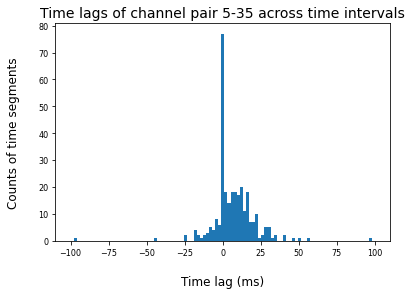

<Figure size 720x1152 with 0 Axes>

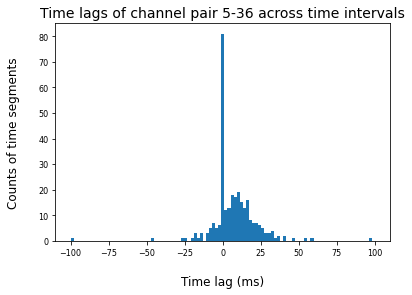

<Figure size 720x1152 with 0 Axes>

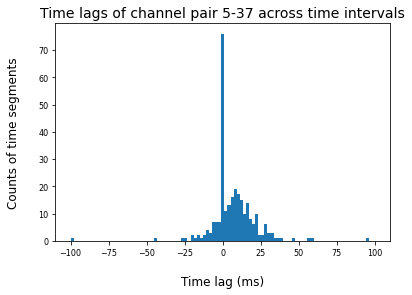

<Figure size 720x1152 with 0 Axes>

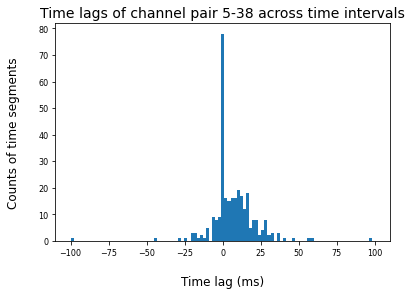

<Figure size 720x1152 with 0 Axes>

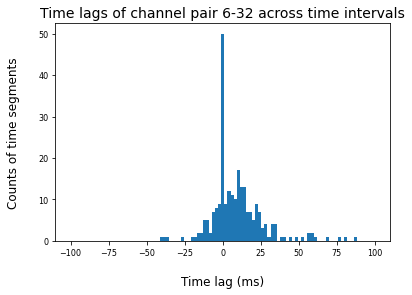

<Figure size 720x1152 with 0 Axes>

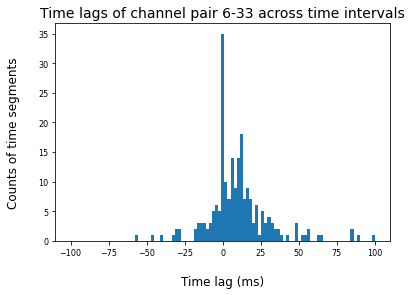

<Figure size 720x1152 with 0 Axes>

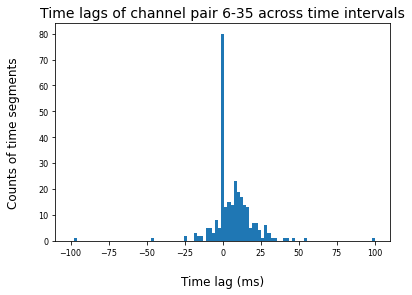

<Figure size 720x1152 with 0 Axes>

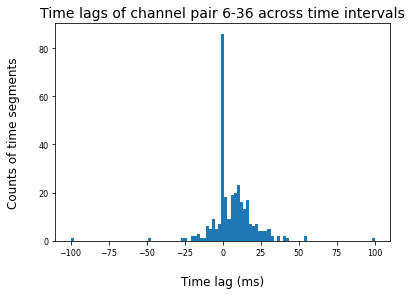

<Figure size 720x1152 with 0 Axes>

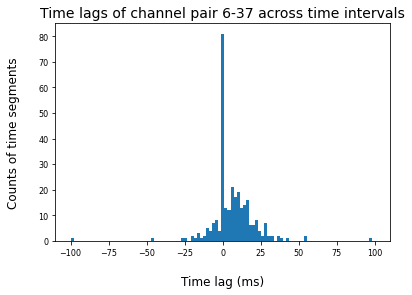

<Figure size 720x1152 with 0 Axes>

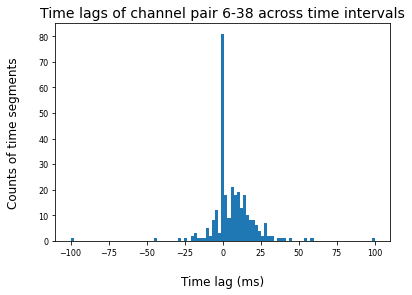

<Figure size 720x1152 with 0 Axes>

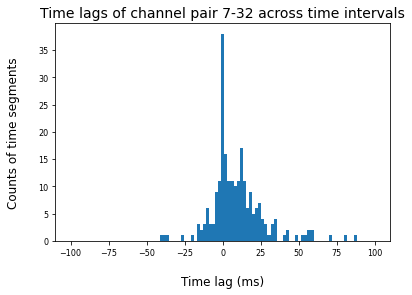

<Figure size 720x1152 with 0 Axes>

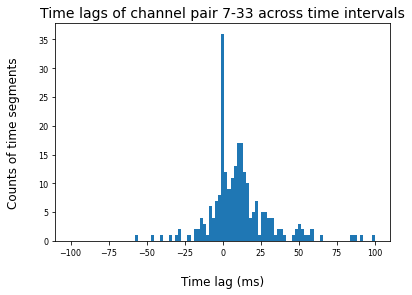

<Figure size 720x1152 with 0 Axes>

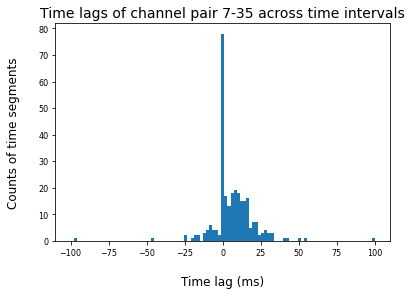

<Figure size 720x1152 with 0 Axes>

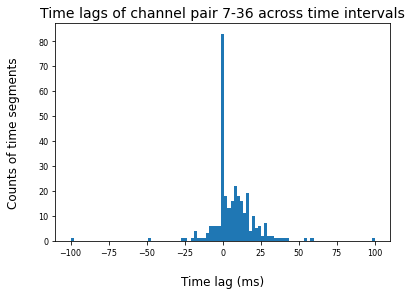

<Figure size 720x1152 with 0 Axes>

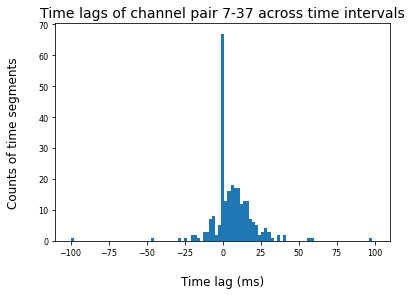

<Figure size 720x1152 with 0 Axes>

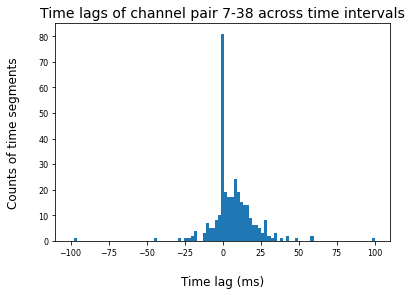

<Figure size 720x1152 with 0 Axes>

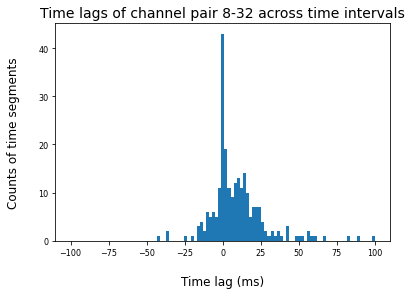

<Figure size 720x1152 with 0 Axes>

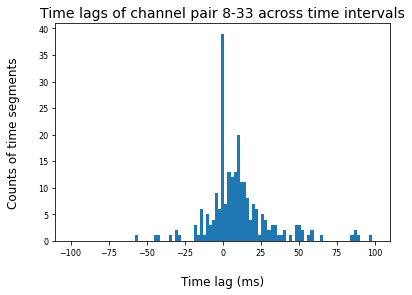

<Figure size 720x1152 with 0 Axes>

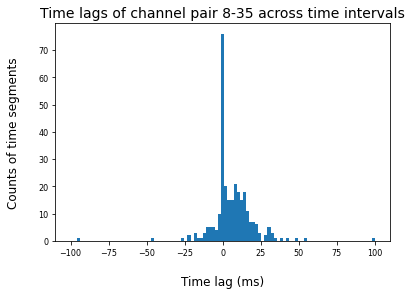

<Figure size 720x1152 with 0 Axes>

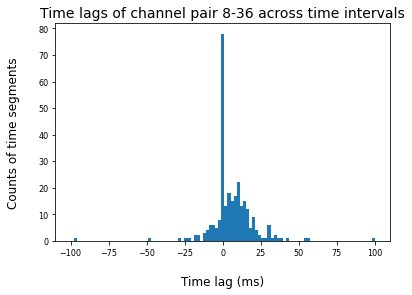

<Figure size 720x1152 with 0 Axes>

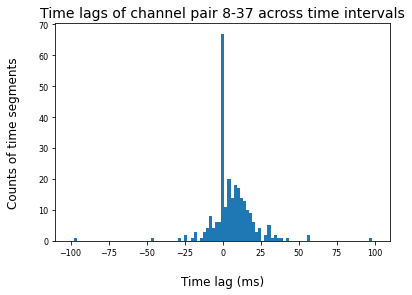

<Figure size 720x1152 with 0 Axes>

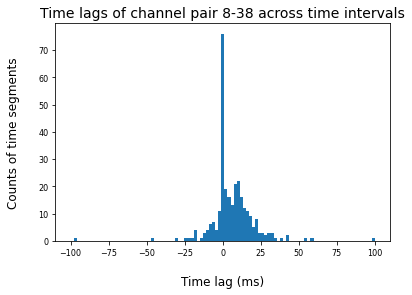

<Figure size 720x1152 with 0 Axes>

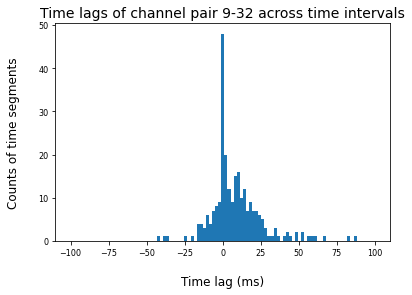

<Figure size 720x1152 with 0 Axes>

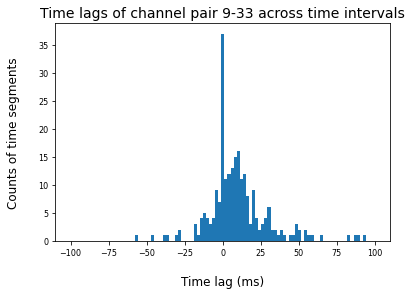

<Figure size 720x1152 with 0 Axes>

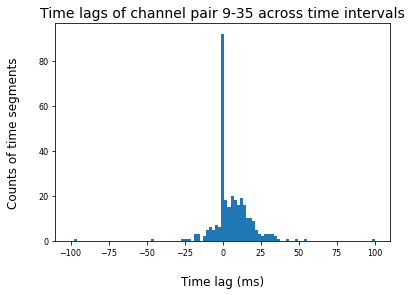

<Figure size 720x1152 with 0 Axes>

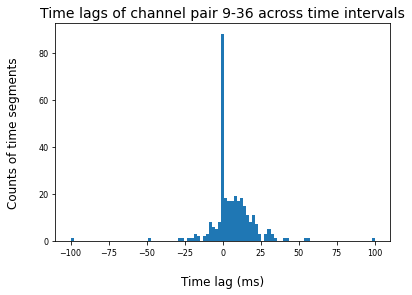

<Figure size 720x1152 with 0 Axes>

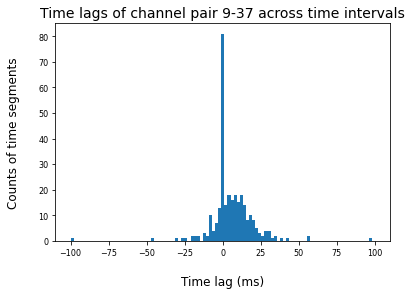

<Figure size 720x1152 with 0 Axes>

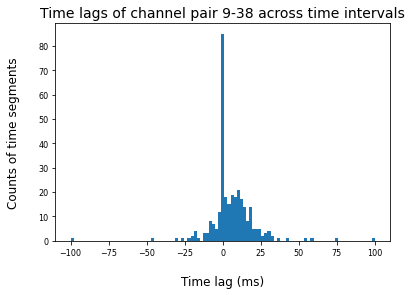

<Figure size 720x1152 with 0 Axes>

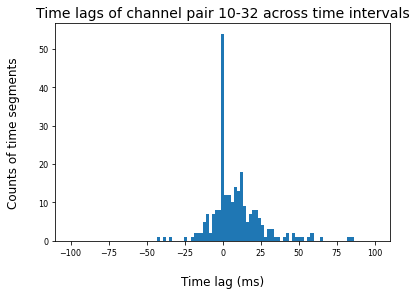

<Figure size 720x1152 with 0 Axes>

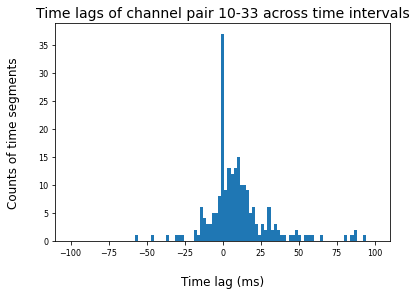

<Figure size 720x1152 with 0 Axes>

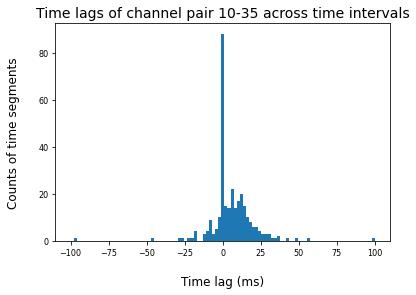

<Figure size 720x1152 with 0 Axes>

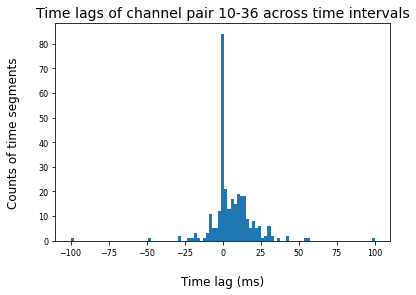

<Figure size 720x1152 with 0 Axes>

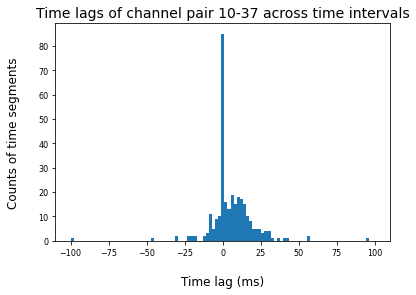

<Figure size 720x1152 with 0 Axes>

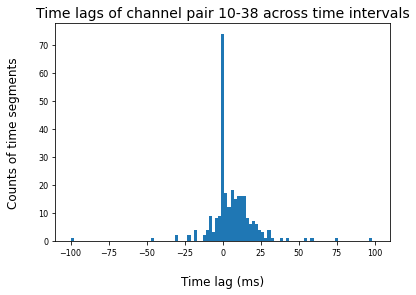

<Figure size 720x1152 with 0 Axes>

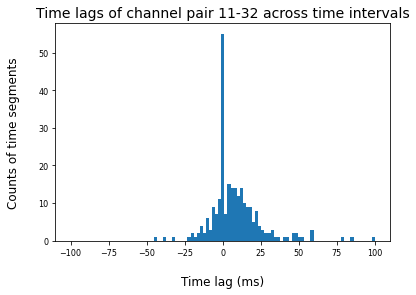

<Figure size 720x1152 with 0 Axes>

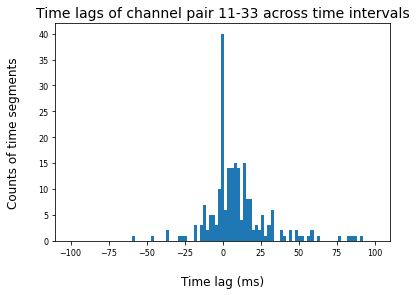

<Figure size 720x1152 with 0 Axes>

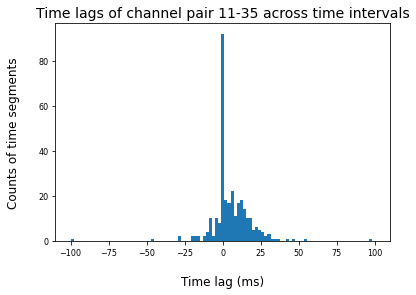

<Figure size 720x1152 with 0 Axes>

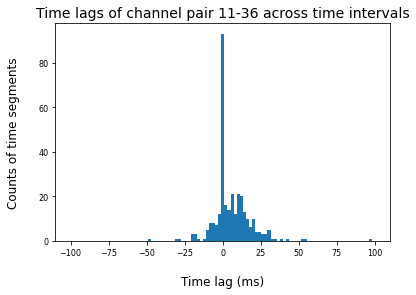

<Figure size 720x1152 with 0 Axes>

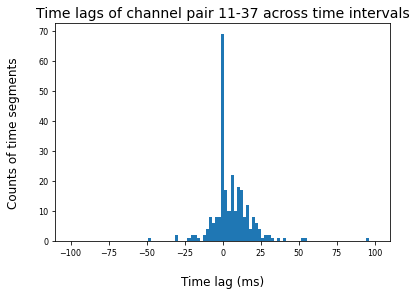

<Figure size 720x1152 with 0 Axes>

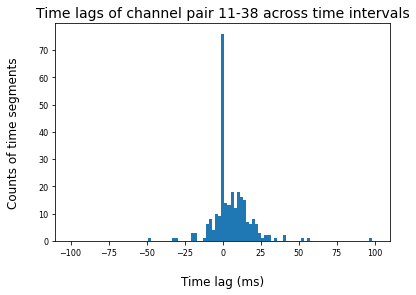

<Figure size 720x1152 with 0 Axes>

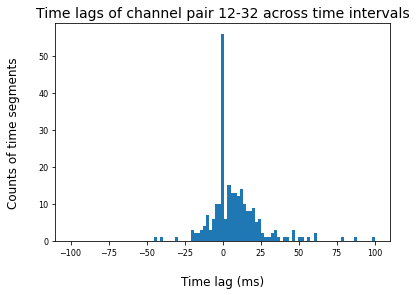

<Figure size 720x1152 with 0 Axes>

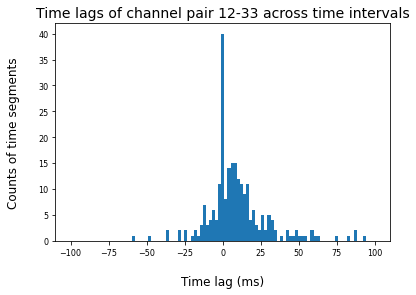

<Figure size 720x1152 with 0 Axes>

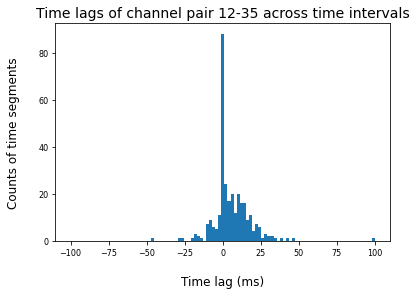

<Figure size 720x1152 with 0 Axes>

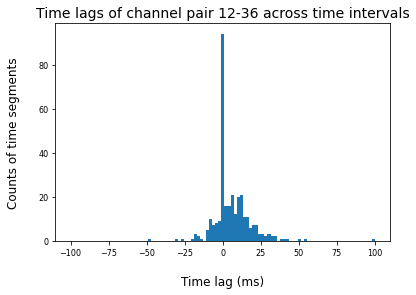

<Figure size 720x1152 with 0 Axes>

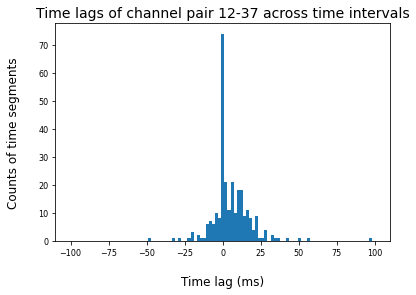

<Figure size 720x1152 with 0 Axes>

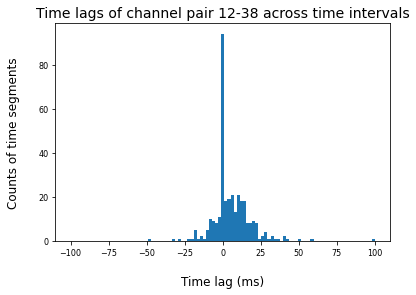

<Figure size 720x1152 with 0 Axes>

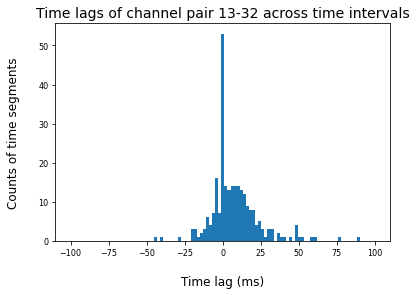

<Figure size 720x1152 with 0 Axes>

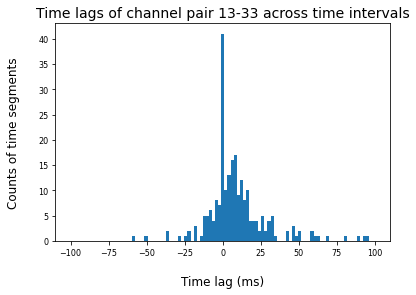

<Figure size 720x1152 with 0 Axes>

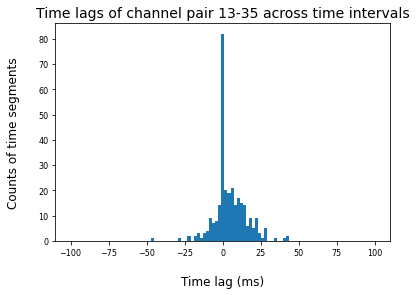

<Figure size 720x1152 with 0 Axes>

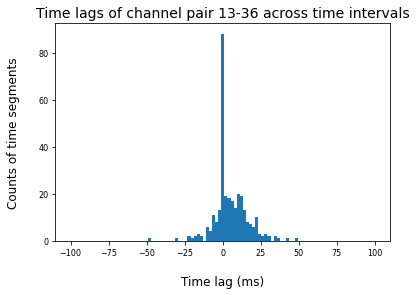

<Figure size 720x1152 with 0 Axes>

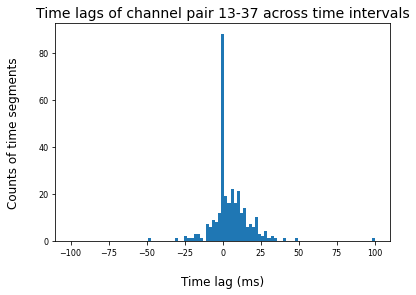

<Figure size 720x1152 with 0 Axes>

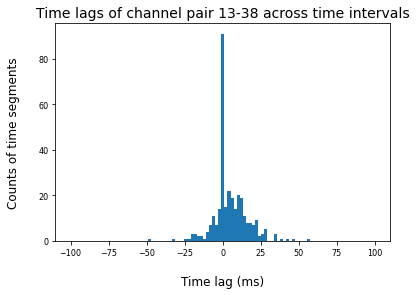

<Figure size 720x1152 with 0 Axes>

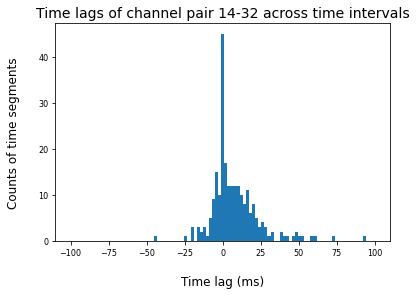

<Figure size 720x1152 with 0 Axes>

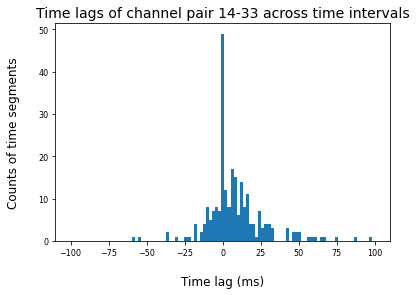

<Figure size 720x1152 with 0 Axes>

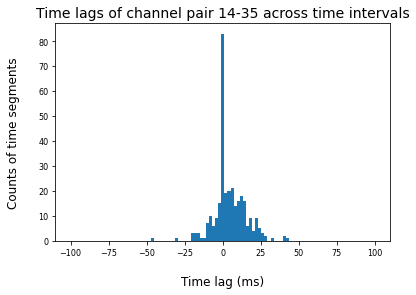

<Figure size 720x1152 with 0 Axes>

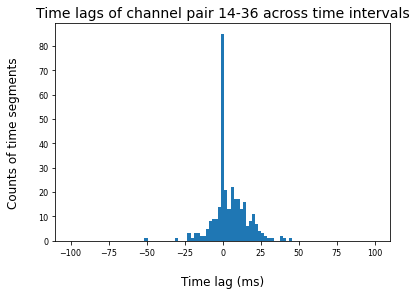

<Figure size 720x1152 with 0 Axes>

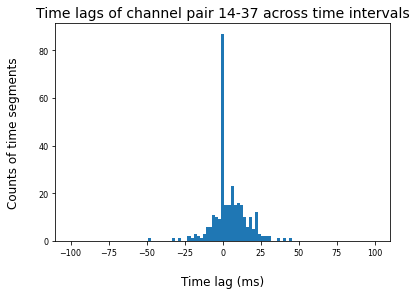

<Figure size 720x1152 with 0 Axes>

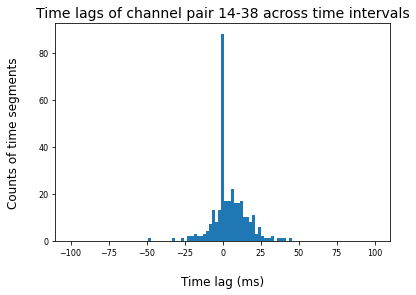

<Figure size 720x1152 with 0 Axes>

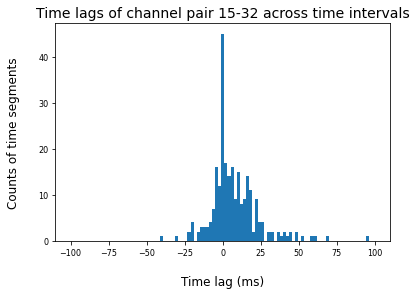

<Figure size 720x1152 with 0 Axes>

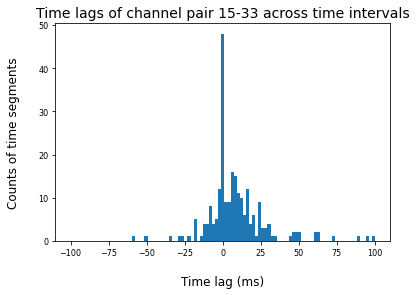

<Figure size 720x1152 with 0 Axes>

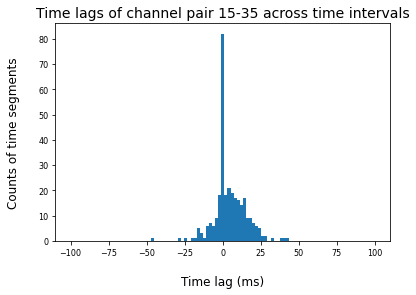

<Figure size 720x1152 with 0 Axes>

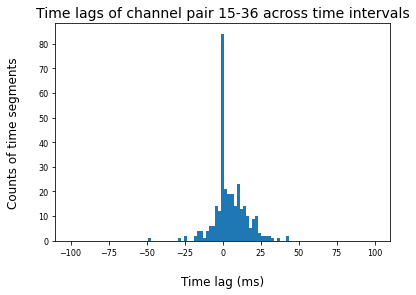

<Figure size 720x1152 with 0 Axes>

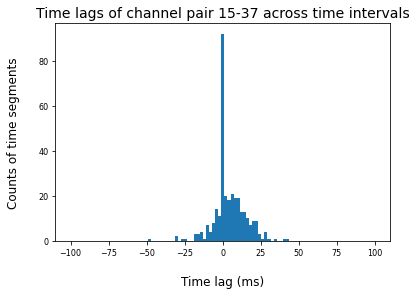

<Figure size 720x1152 with 0 Axes>

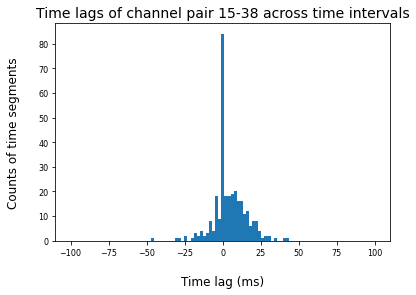

<Figure size 720x1152 with 0 Axes>

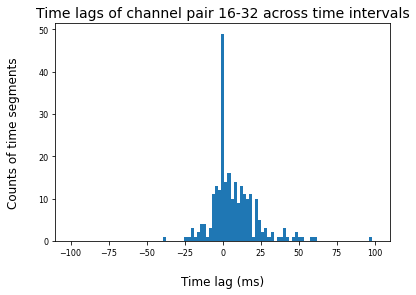

<Figure size 720x1152 with 0 Axes>

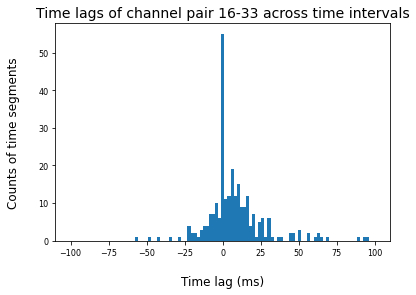

<Figure size 720x1152 with 0 Axes>

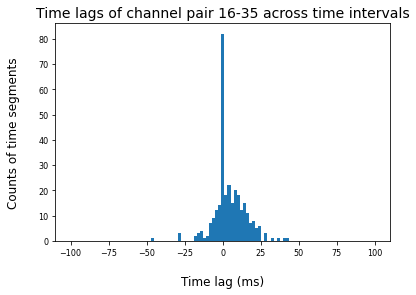

<Figure size 720x1152 with 0 Axes>

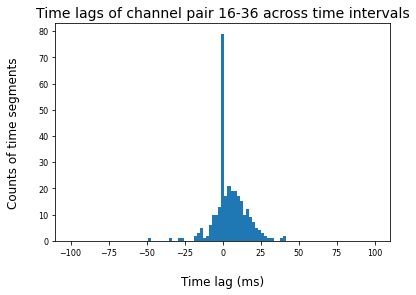

<Figure size 720x1152 with 0 Axes>

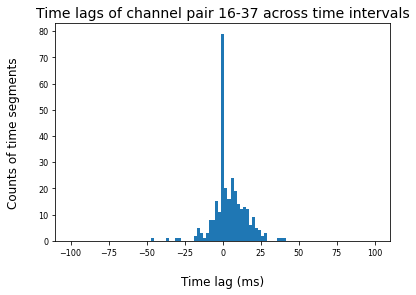

<Figure size 720x1152 with 0 Axes>

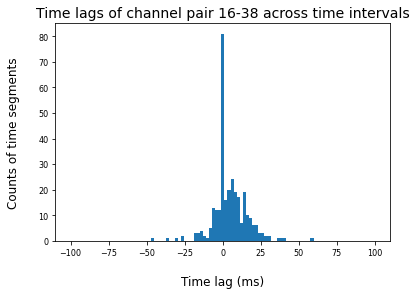

<Figure size 720x1152 with 0 Axes>

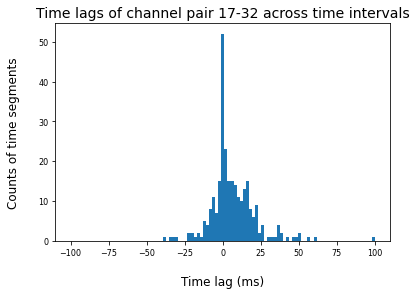

<Figure size 720x1152 with 0 Axes>

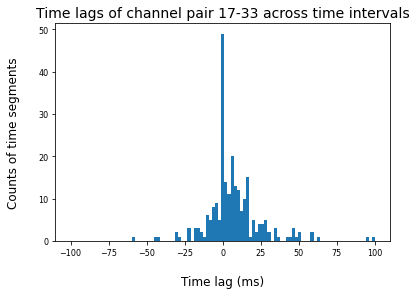

<Figure size 720x1152 with 0 Axes>

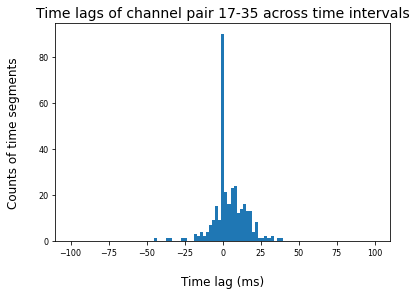

<Figure size 720x1152 with 0 Axes>

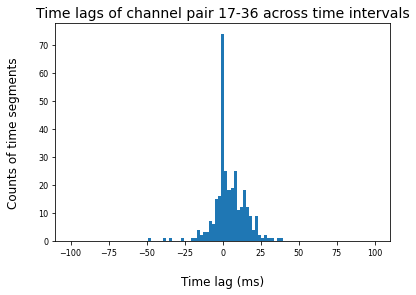

<Figure size 720x1152 with 0 Axes>

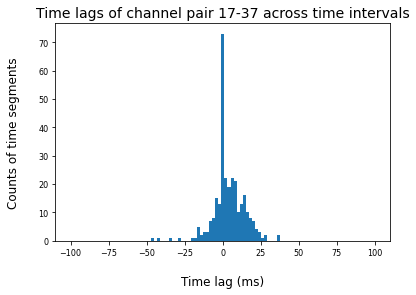

<Figure size 720x1152 with 0 Axes>

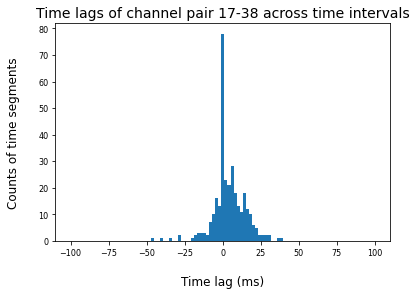

<Figure size 720x1152 with 0 Axes>

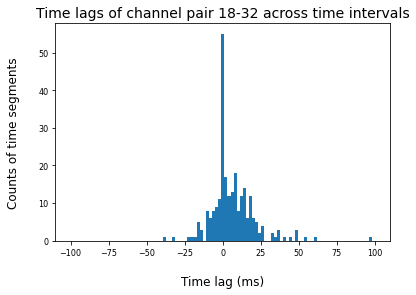

<Figure size 720x1152 with 0 Axes>

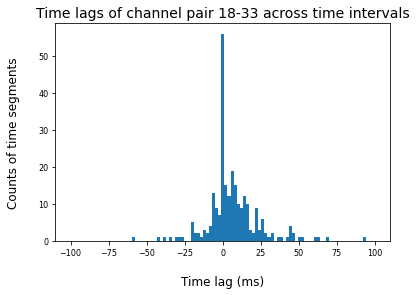

<Figure size 720x1152 with 0 Axes>

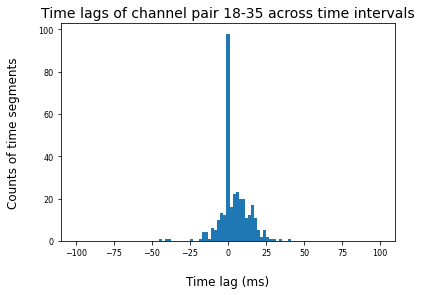

<Figure size 720x1152 with 0 Axes>

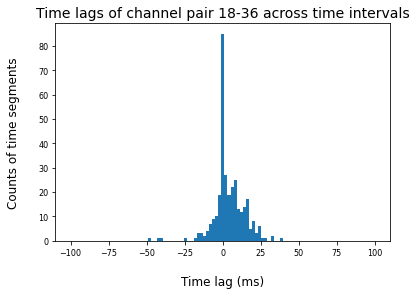

<Figure size 720x1152 with 0 Axes>

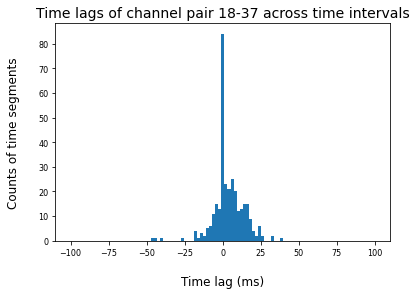

<Figure size 720x1152 with 0 Axes>

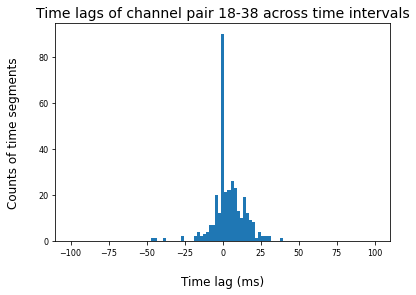

<Figure size 720x1152 with 0 Axes>

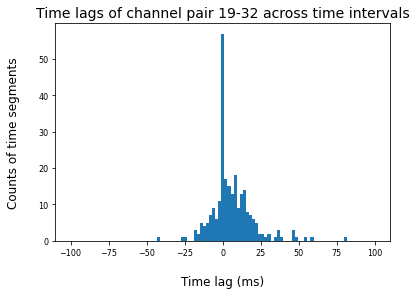

<Figure size 720x1152 with 0 Axes>

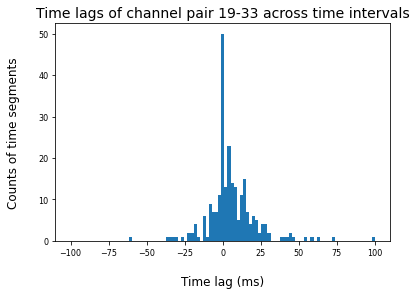

<Figure size 720x1152 with 0 Axes>

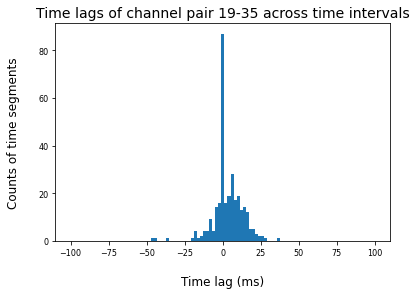

<Figure size 720x1152 with 0 Axes>

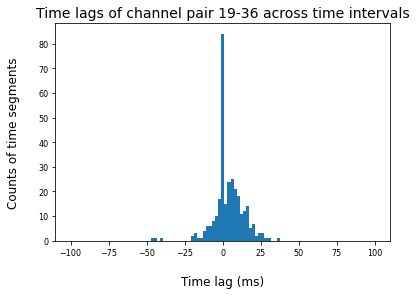

<Figure size 720x1152 with 0 Axes>

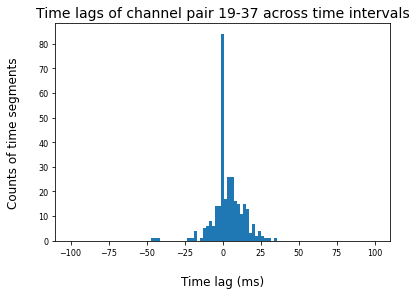

<Figure size 720x1152 with 0 Axes>

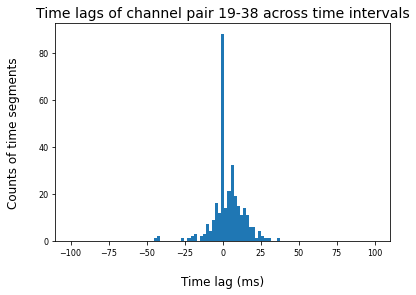

<Figure size 720x1152 with 0 Axes>

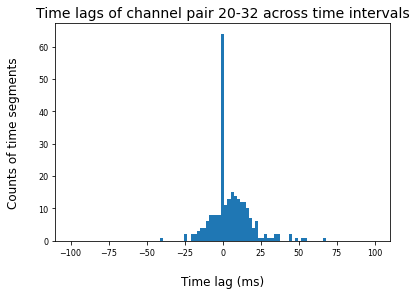

<Figure size 720x1152 with 0 Axes>

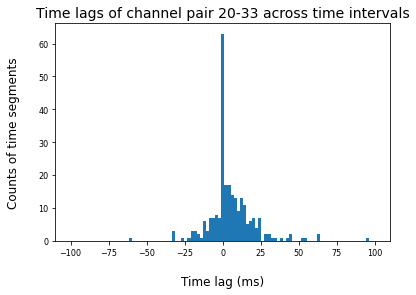

<Figure size 720x1152 with 0 Axes>

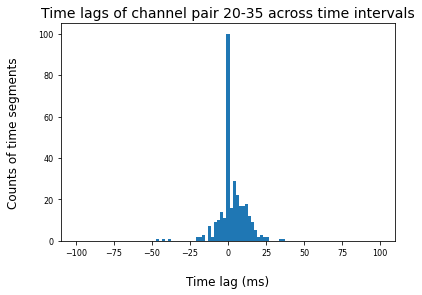

<Figure size 720x1152 with 0 Axes>

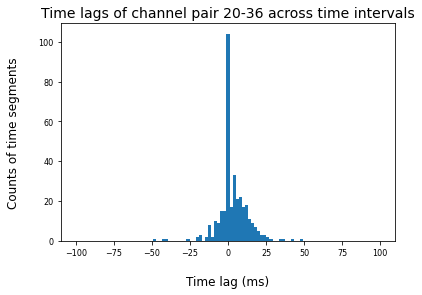

<Figure size 720x1152 with 0 Axes>

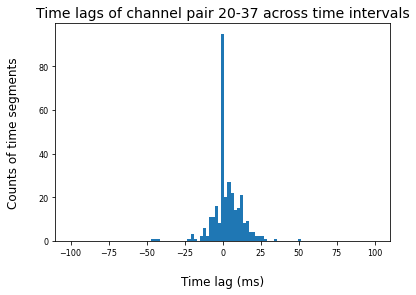

<Figure size 720x1152 with 0 Axes>

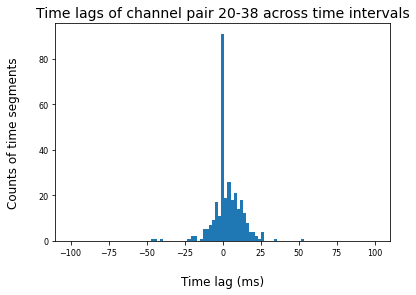

<Figure size 720x1152 with 0 Axes>

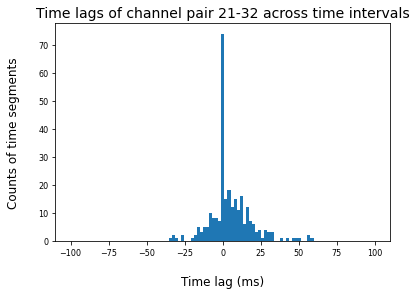

<Figure size 720x1152 with 0 Axes>

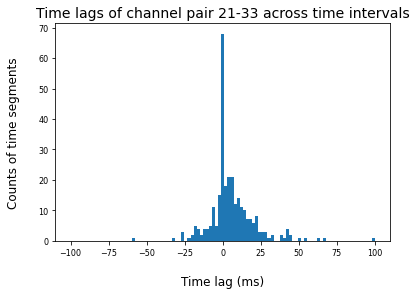

<Figure size 720x1152 with 0 Axes>

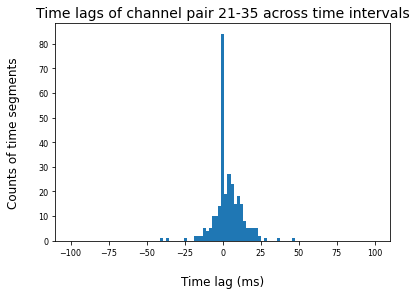

<Figure size 720x1152 with 0 Axes>

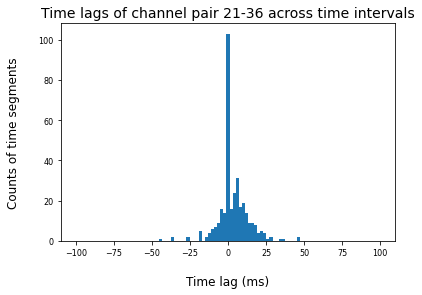

<Figure size 720x1152 with 0 Axes>

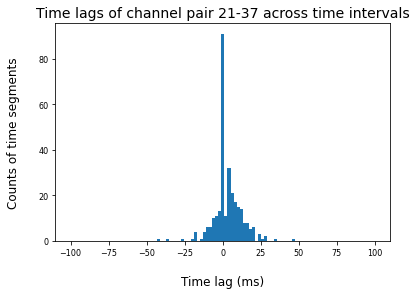

<Figure size 720x1152 with 0 Axes>

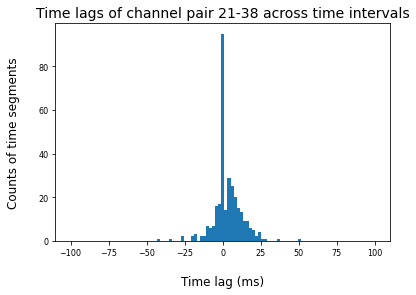

<Figure size 720x1152 with 0 Axes>

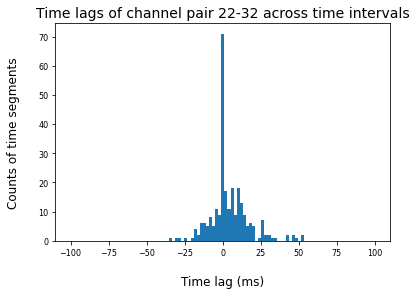

<Figure size 720x1152 with 0 Axes>

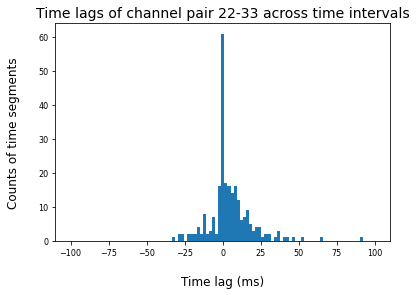

<Figure size 720x1152 with 0 Axes>

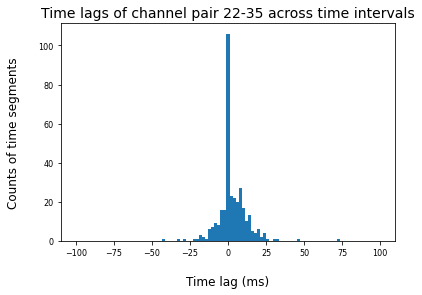

<Figure size 720x1152 with 0 Axes>

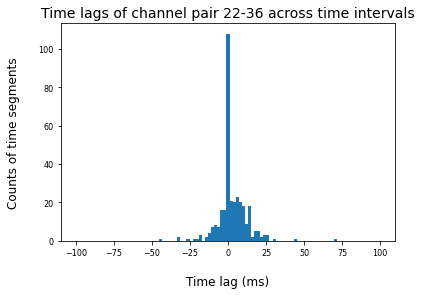

<Figure size 720x1152 with 0 Axes>

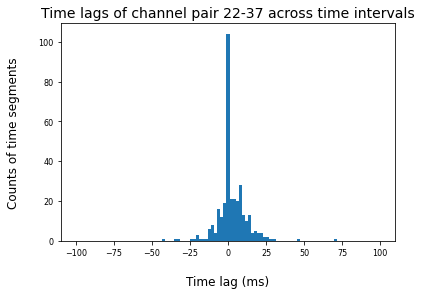

<Figure size 720x1152 with 0 Axes>

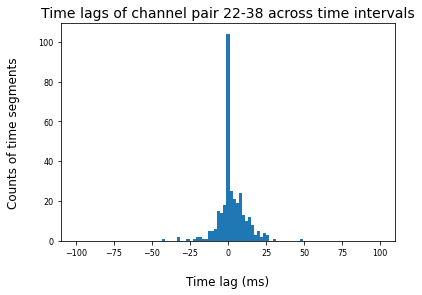

<Figure size 720x1152 with 0 Axes>

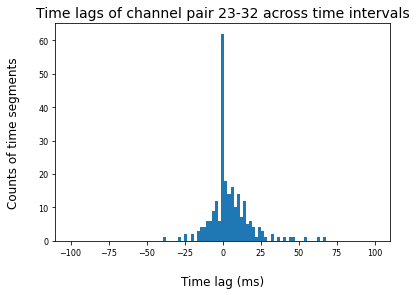

<Figure size 720x1152 with 0 Axes>

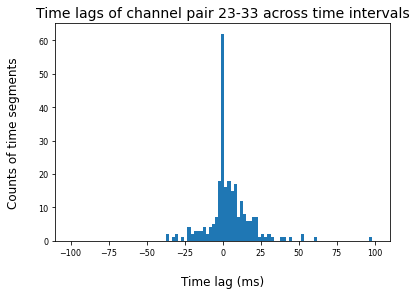

<Figure size 720x1152 with 0 Axes>

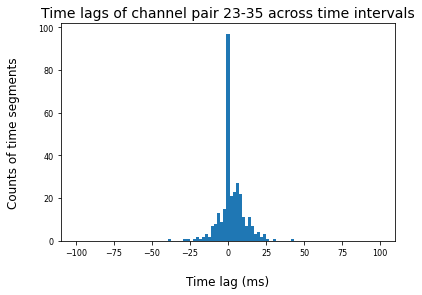

<Figure size 720x1152 with 0 Axes>

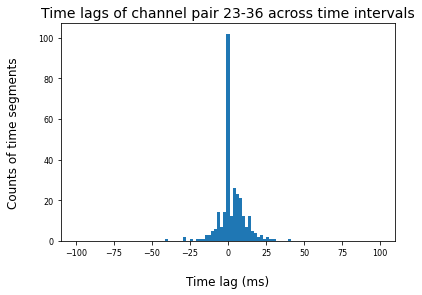

<Figure size 720x1152 with 0 Axes>

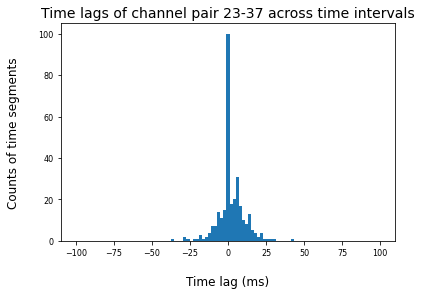

<Figure size 720x1152 with 0 Axes>

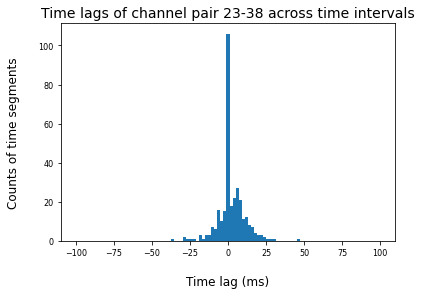

<Figure size 720x1152 with 0 Axes>

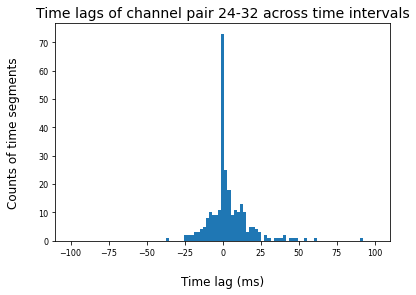

<Figure size 720x1152 with 0 Axes>

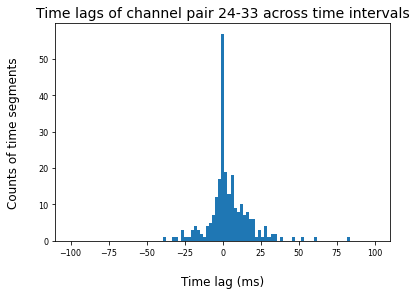

<Figure size 720x1152 with 0 Axes>

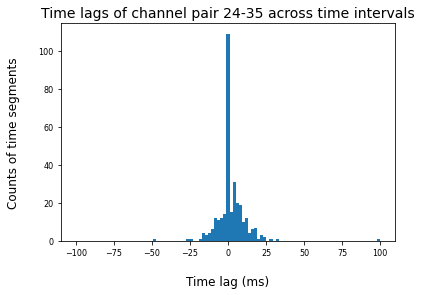

<Figure size 720x1152 with 0 Axes>

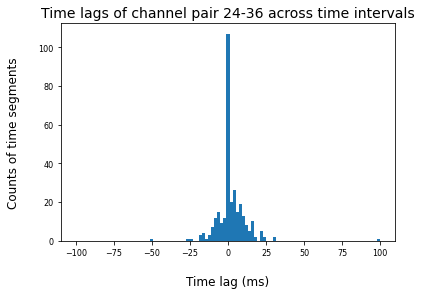

<Figure size 720x1152 with 0 Axes>

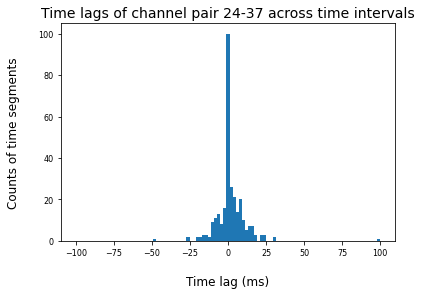

<Figure size 720x1152 with 0 Axes>

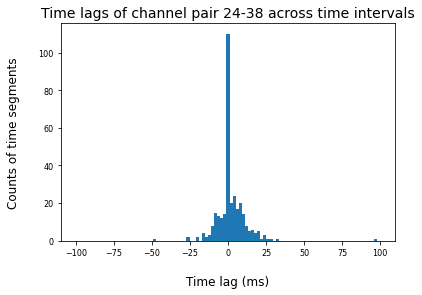

<Figure size 720x1152 with 0 Axes>

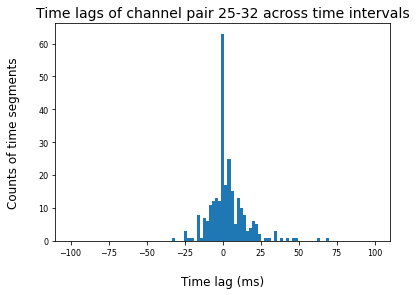

<Figure size 720x1152 with 0 Axes>

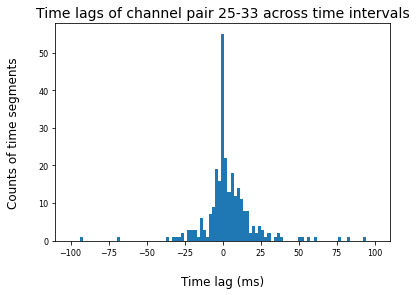

<Figure size 720x1152 with 0 Axes>

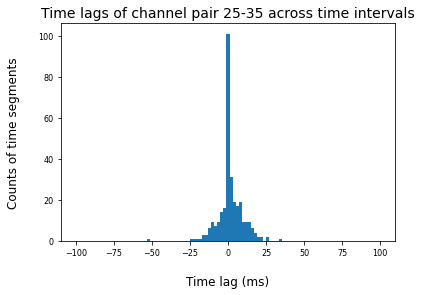

<Figure size 720x1152 with 0 Axes>

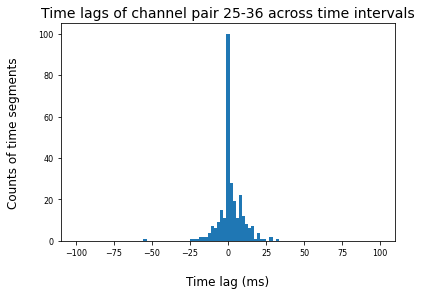

<Figure size 720x1152 with 0 Axes>

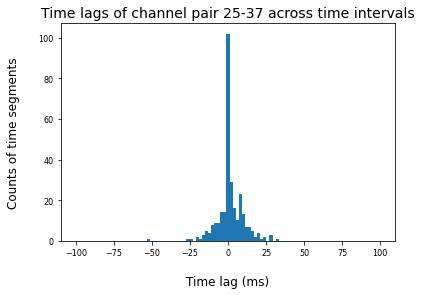

<Figure size 720x1152 with 0 Axes>

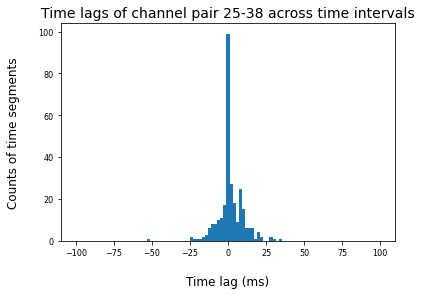

<Figure size 720x1152 with 0 Axes>

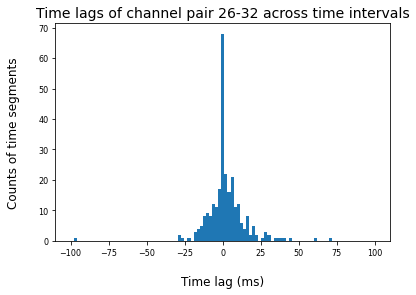

<Figure size 720x1152 with 0 Axes>

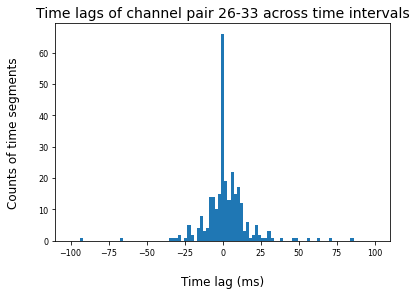

<Figure size 720x1152 with 0 Axes>

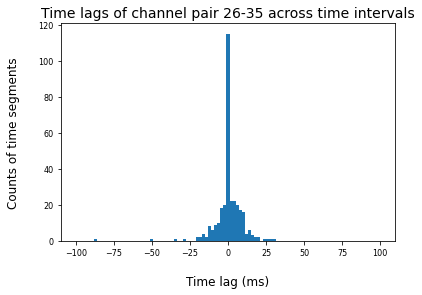

<Figure size 720x1152 with 0 Axes>

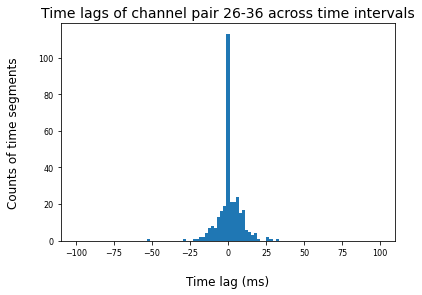

<Figure size 720x1152 with 0 Axes>

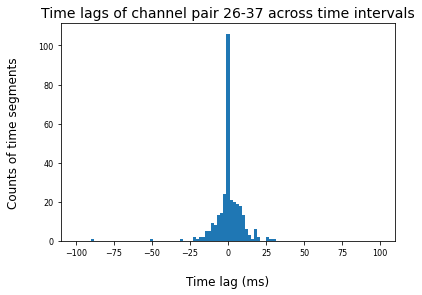

<Figure size 720x1152 with 0 Axes>

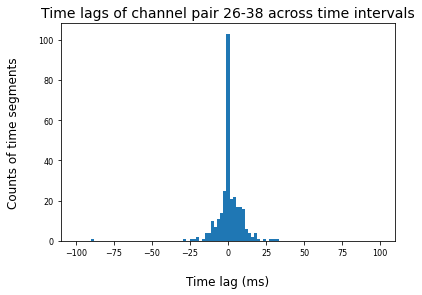

<Figure size 720x1152 with 0 Axes>

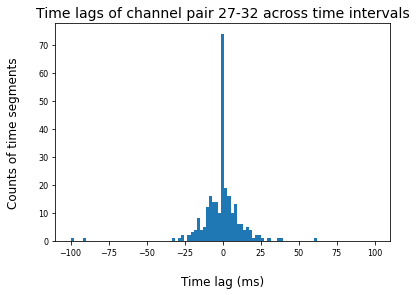

<Figure size 720x1152 with 0 Axes>

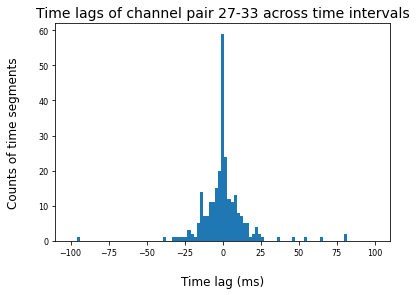

<Figure size 720x1152 with 0 Axes>

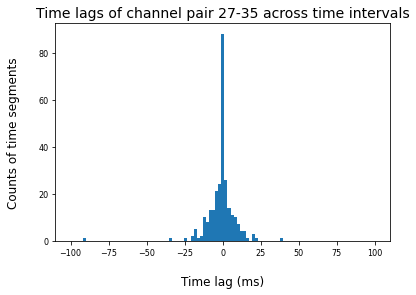

<Figure size 720x1152 with 0 Axes>

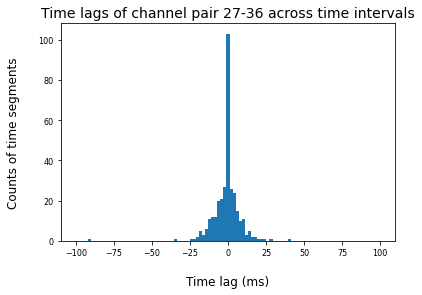

<Figure size 720x1152 with 0 Axes>

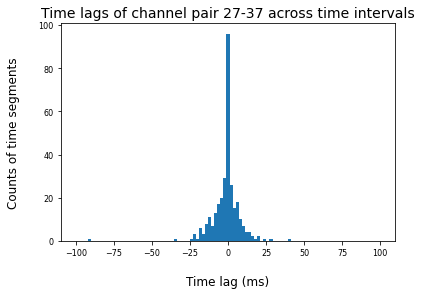

<Figure size 720x1152 with 0 Axes>

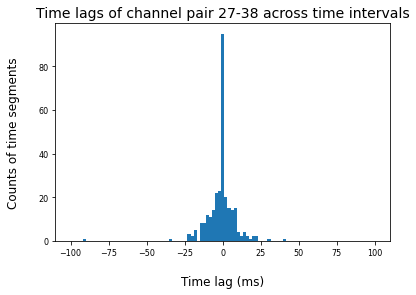

<Figure size 720x1152 with 0 Axes>

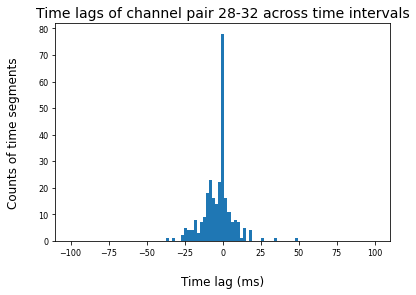

<Figure size 720x1152 with 0 Axes>

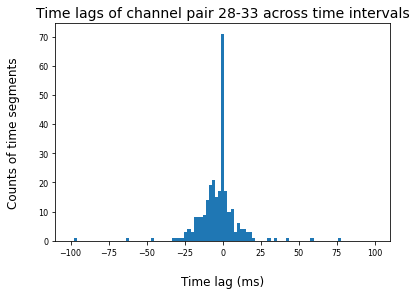

<Figure size 720x1152 with 0 Axes>

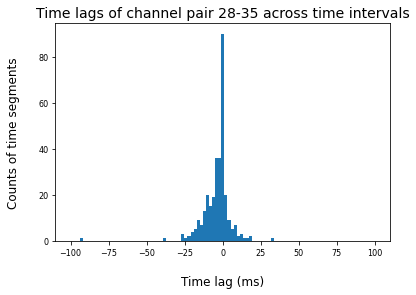

<Figure size 720x1152 with 0 Axes>

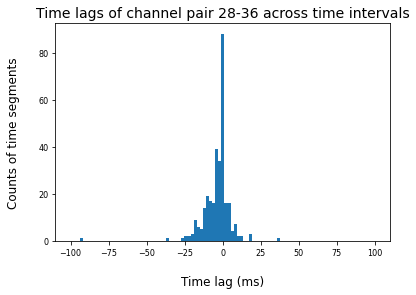

<Figure size 720x1152 with 0 Axes>

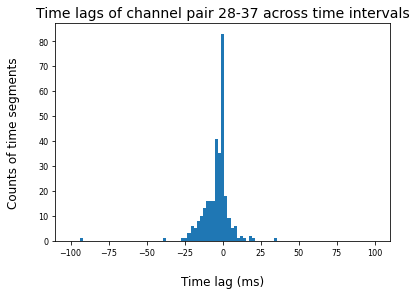

<Figure size 720x1152 with 0 Axes>

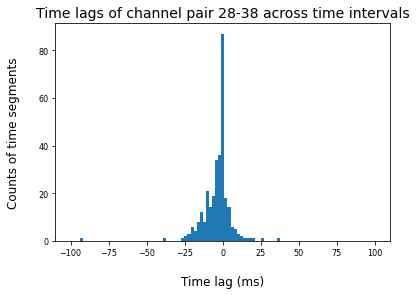

<Figure size 720x1152 with 0 Axes>

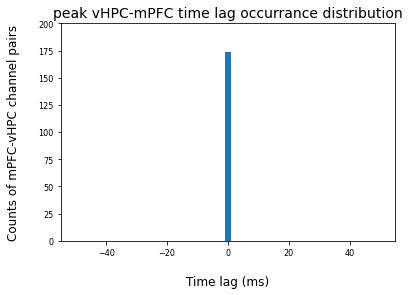

<Figure size 720x1152 with 0 Axes>

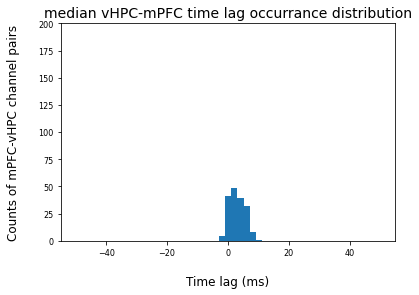

<Figure size 720x1152 with 0 Axes>

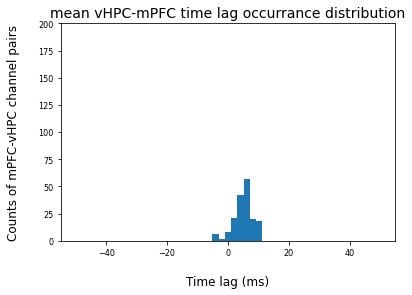

In [7]:
plotting.plot_seg_lags(results_seg_lag_open, savedir+'seg_lags_open/', seglen=0.5)
plotting.plot_seg_lags(results_seg_lag_closed, savedir+'seg_lags_closed/', seglen=0.5)

In [ ]:
closed_seg_starts = results_seg_lag_closed['segment_starts']

inner_circle = plt.Circle((202, 204), 144, color='k', fill=False)
outer_circle = plt.Circle((202, 204), 176, color='k', fill=False)
#edges
x1, y1 = [360, 44], [388, 20]
x2, y2 = [400, 4], [40, 368]

fig, ax = plt.subplots(figsize=(10,10))
ax.add_patch(inner_circle)
ax.add_patch(outer_circle)
ax.plot(x1, y1, color='k')
ax.plot(x2, y2, color='k')
ax.set_xlim(0, 400)
ax.set_ylim(0, 400)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

traj_x = events['movement']['calib_traj_x']
traj_y = events['movement']['calib_traj_y']
rois = events['rois_stats']['roi_at_each_frame']
beh_start = int(start_time * f_behavior)
beh_end = int((start_time + behavior_window_duration) * f_behavior)
for i in range(40):
    video_start = closed_seg_starts[i] + int(f_behavior * behavior_trigger)
    video_end = video_start + int(0.5 * f_behavior)
    ax.plot(traj_x[video_start:video_end], traj_y[video_start:video_end], color='b')

plt.show()

print(closed_seg_starts[20])